# Imports and useful functions

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from collections import namedtuple

def make_plot_look_good(axes):
    axes.axhline(0, color=[0.2, 0.2, 0.2], linewidth=1)
    axes.axvline(0, color=[0.2, 0.2, 0.2], linewidth=1)
    axes.grid(True, which='both', linestyle='--', linewidth=0.5)
    for spine in axes.spines.values():
        spine.set_visible(False)

def set_axes_labels(axes, x_label, y_label, title, legend_title=None, fontsize=7):
    axes.set_xlabel(x_label, fontsize=fontsize)
    axes.set_ylabel(y_label, fontsize=fontsize)
    axes.set_title(title, fontsize=fontsize)
    if legend_title is not None:
        axes.legend(title=legend_title,bbox_to_anchor=(1,1))
    make_plot_look_good(axes)


def simulate_binding_recycling_and_degradation(t, rate_constants, state_variable_metadata):
    # concatenate state variable initial values into a list
    x_initial_value = np.array( [ iv.initial_value for iv in state_variable_metadata.values() ] )

    # call solve_ivp. this problem is stiff, so it is necessary to use an algorithm that can handle stiff systems.
    solution = solve_ivp(dydt, [t[0], t[-1]], x_initial_value,
                         args=(rate_constants, state_variable_metadata),
                         t_eval=t,
                         atol=1e-40,
                         dense_output=True,
                         method='Radau')

    # create a dictionary with keys equal to state variable names and values equal to simulation
    # this is handy for plotting or just accessing the state variable values
    simulation_results_dictionary = dict( (key, value) for key, value in zip(state_variable_metadata.keys(), solution.y) )
    # add time axis to results
    simulation_results_dictionary['t'] = t

    return simulation_results_dictionary, solution



# Simulation information: species and rate constants

In [109]:
# compute the initial concentration of receptors
#number_of_cells = 1e9
#avogadros_number = 6.022e23
#blood_volume = 4 # liters
#initial_receptor_concentration = number_of_cells * initial_receptors_per_cell / avogadros_number / blood_volume

StateVariableMetadata = namedtuple('StateVariableMetadata', ['description', 'initial_value', 'units'])

# wrapper for metadata, to make looping easier later
def state_variable_metadata(ligand=50e-6, adam=50e-6, r1s=50e4, r2s=50e4):
    return {
    'L': StateVariableMetadata(description="Ligand (EGF)", initial_value=ligand, units='M'),
    'A': StateVariableMetadata(description="ADAM10", initial_value=adam, units='M'),

    # SURFACE SPECIES
    'R1s': StateVariableMetadata(description="Surface Monomeric EGFR", initial_value=r1s, units='#/cell'),
    'R2s': StateVariableMetadata(description="Surface Monomeric HER2", initial_value=r2s, units='#/cell'),
    'R1/R2s': StateVariableMetadata(description="Surface Dimeric EGFR/HER2", initial_value=0, units='#/cell'),
    'R1/R1s': StateVariableMetadata(description="Surface Dimeric EGFR/EGFR", initial_value=0, units='#/cell'),
    'R2/R2s': StateVariableMetadata(description="Surface Dimeric HER2/HER2", initial_value=0, units='#/cell'),
    'R1/Ls': StateVariableMetadata(description="Surface EGF-bound EGFR", initial_value=0, units='#/cell'),
    'R1/R1/Ls': StateVariableMetadata(description="Surface Singly EGF-\nbound EGFR/EGFR", initial_value=0, units='#/cell'),
    'L/R1/R1/Ls': StateVariableMetadata(description="Surface Doubly EGF-\nbound EGFR/EGFR", initial_value=0, units='#/cell'),
    'L/R1/R2s': StateVariableMetadata(description="Surface EGF-bound EGFR/HER2", initial_value=0, units='#/cell'),
    'sheds': StateVariableMetadata(description="Surface HER w/o ectodomain", initial_value=0, units='#/cell'),

    # INTERNAL SPECIES
    'R1i': StateVariableMetadata(description="Internal Monomeric EGFR", initial_value=0, units='#/cell'),
    'R2i': StateVariableMetadata(description="Internal Monomeric HER2", initial_value=0, units='#/cell'),
    'R1/R2i': StateVariableMetadata(description="Internal Dimeric EGFR/HER2", initial_value=0, units='#/cell'),
    'R1/R1i': StateVariableMetadata(description="Internal Dimeric EGFR/EGFR", initial_value=0, units='#/cell'),
    'R2/R2i': StateVariableMetadata(description="Internal Dimeric HER2/HER2", initial_value=0, units='#/cell'),
    'R1/Li': StateVariableMetadata(description="Internal EGF-bound EGFR", initial_value=0, units='#/cell'),
    'R1/R1/Li': StateVariableMetadata(description="Internal Singly EGF-\nbound EGFR/EGFR", initial_value=0, units='#/cell'),
    'L/R1/R1/Li': StateVariableMetadata(description="Internal Doubly EGF-\nbound EGFR/EGFR", initial_value=0, units='#/cell'),
    'L/R1/R2i': StateVariableMetadata(description="Internal EGF-bound EGFR/HER2", initial_value=0, units='#/cell'),
    'shedi': StateVariableMetadata(description="Internal HER w/o ectodomain", initial_value=0, units='#/cell'),
    'Ras-GTP': StateVariableMetadata(description="Active Ras", initial_value=0, units='#/cell'),
}

# wrapper for constants, to make looping easier later
def rate_constants(k_c=1e-3, k_on=9.7e7, k_off=0.24, V_s=100, k_shed=100):
    return {
    # dimerization and uncoupling parameters; taken from Hendriks 2003
    'k_c': k_c,         # /( #/cell min )   same for all dimers
    'k_uR1/R1': 10,      # /min
    'k_uR1/R2': 10,      # /min
    'k_uR2/R2': 1,       # /min
    'k_uR1/R1/L': 0.1,   # /min (guess)
    'k_uL/R1/R2': 0.1,   # /min
    'k_uL/R1/R1/L': 0.1, # /min

    # EGF association with EGFR; taken from Hendriks 2003
    'k_on': k_on,       # /(M min)
    'k_off': k_off,        # /min

    # internalization; taken from Hendriks 2003 plus assumptions
    # 'k_eR1': 0.01e-4,
    # 'k_eR2': 0.03e-4,       # /min    this is 0.01 WITHOUT EGF, else 0.03!
    # 'k_edimer': 0.04e-4,    # /min    assumed to be equal for all dimers (value pulled from paper for k_eR1/R1)
    # 'k_eR1/L': 0.28e-2,     # /min
    # 'k_edimer/L':0.1e-2,    # /min    assumed to be equal for all dimers and singly/doubly bound ligand (value pulled from paper for L/R1/R2)
    # 'k_eshed': 0.1e-2,
    'k_eR1': 0.08,
    'k_eR2': 0.03,       # /min    this is 0.01 WITHOUT EGF, else 0.03!
    'k_edimer': 0.04,    # /min    assumed to be equal for all dimers (value pulled from paper for k_eR1/R1)
    'k_eR1/L': 0.28,     # /min
    'k_edimer/L':0.1,    # /min    assumed to be equal for all dimers and singly/doubly bound ligand (value pulled from paper for L/R1/R2)
    'k_eshed': 0.1,

    # degradation; guesses based on pset 4, plus assumption that EGF-bound degrades faster than unbound receptors
    'k_degdimer': 0.01,
    'k_degdimer/L': 0.02,
    'k_degR1': 0.01,
    'k_degR1/L': 0.02,
    'k_degR2': 0.01,

     # synthesis of surface R1 and R2 (assumed equal)
    'V_s': V_s,  # #/(cell min)    assume a few orders less than initial receptor concentration

    # shedding
    'k_shed': k_shed # Kcat = 10-10000 /sec for proteases in general
 }


# Implement rate equations

In [110]:

def dydt(t, y, rate_constants, state_variable_metadata):
    state_variable_values = dict( zip( state_variable_metadata.keys(), y ) )

    derivatives = dict()

    derivatives['L'] = (
        - rate_constants['k_on']*state_variable_values['L']*(state_variable_values['R1/R1s'] +
                                                             state_variable_values['R1s'] +
                                                             state_variable_values['R1/R2s'] +
                                                             state_variable_values['R1/R1/Ls'])
        + rate_constants['k_off']*(state_variable_values['R1/R1/Ls'] +
                                  state_variable_values['R1/Ls'] +
                                  state_variable_values['L/R1/R2s'] +
                                  state_variable_values['L/R1/R1/Ls'])
    )

    derivatives['A'] = 0   # ADAM10 is an enzyme, so don't want it depleted or synthesized 

    # SURFACE DERIVATIVES
    derivatives['R1/R1s'] = (
        rate_constants['k_c']*state_variable_values['R1s']**2
        - rate_constants['k_uR1/R1']*state_variable_values['R1/R1s']
        - rate_constants['k_edimer']*state_variable_values['R1/R1s']
        - rate_constants['k_on']*state_variable_values['R1/R1s']*state_variable_values['L']
        + rate_constants['k_off']*state_variable_values['R1/R1/Ls']
    )
    derivatives['R1/R1/Ls'] = (
        rate_constants['k_c']*state_variable_values['R1s']*state_variable_values['R1/Ls']
        - rate_constants['k_uR1/R1/L']*state_variable_values['R1/R1/Ls']
        - rate_constants['k_edimer/L']*state_variable_values['R1/R1/Ls']
        + rate_constants['k_on']*state_variable_values['R1/R1s']*state_variable_values['L']
        - rate_constants['k_off']*state_variable_values['R1/R1/Ls']
    )
    derivatives['L/R1/R1/Ls'] = (
        rate_constants['k_c']*state_variable_values['R1/Ls']**2
        - rate_constants['k_uL/R1/R1/L']*state_variable_values['L/R1/R1/Ls']
        - rate_constants['k_edimer/L']*state_variable_values['L/R1/R1/Ls']
        + rate_constants['k_on']*state_variable_values['R1/R1/Ls']*state_variable_values['L']
        - rate_constants['k_off']*state_variable_values['L/R1/R1/Ls']
    )
    derivatives['R2/R2s'] = (
        rate_constants['k_c']*state_variable_values['R2s']**2
        - rate_constants['k_uR2/R2']*state_variable_values['R2/R2s']
        - rate_constants['k_edimer']*state_variable_values['R2/R2s']
    )
    derivatives['R1/R2s'] = (
        rate_constants['k_c']*state_variable_values['R1s']*state_variable_values['R2s']
        - rate_constants['k_uR1/R2']*state_variable_values['R1/R2s']
        - rate_constants['k_edimer']*state_variable_values['R1/R2s']
        - rate_constants['k_on']*state_variable_values['R1/R2s']*state_variable_values['L']
        + rate_constants['k_off']*state_variable_values['L/R1/R2s']
    )
    derivatives['L/R1/R2s'] = (
        rate_constants['k_c']*state_variable_values['R1/Ls']*state_variable_values['R2s']
        - rate_constants['k_uL/R1/R2']*state_variable_values['L/R1/R2s']
        - rate_constants['k_edimer/L']*state_variable_values['L/R1/R2s']
        + rate_constants['k_on']*state_variable_values['R1/R2s']*state_variable_values['L']
        - rate_constants['k_off']*state_variable_values['L/R1/R2s']
    )
    derivatives['R1/Ls'] = (
        rate_constants['k_on']*state_variable_values['R1s']*state_variable_values['L']
        - rate_constants['k_off']*state_variable_values['R1/Ls']
        - rate_constants['k_c']*state_variable_values['R1/Ls']*state_variable_values['R2s']
        - 2*rate_constants['k_c']*state_variable_values['R1/Ls']**2
        + 2*rate_constants['k_uL/R1/R1/L']*state_variable_values['L/R1/R1/Ls']
        + rate_constants['k_uL/R1/R2']*state_variable_values['L/R1/R2s']
        - rate_constants['k_eR1/L']*state_variable_values['R1/Ls']
    )
    derivatives['R1s'] = (
        - rate_constants['k_eR1']*state_variable_values['R1s']
        - 2*rate_constants['k_c']*state_variable_values['R1s']**2
        - rate_constants['k_c']*state_variable_values['R1s']*state_variable_values['R2s']
        - rate_constants['k_on']*state_variable_values['R1s']*state_variable_values['L']
        + 2*rate_constants['k_uR1/R1']*state_variable_values['R1/R1s']
        + rate_constants['k_uR1/R2']*state_variable_values['R1/R2s']
        + rate_constants['k_off']*state_variable_values['R1/Ls']
        + rate_constants['k_uR1/R1/L']*state_variable_values['R1/R1/Ls']
        - rate_constants['k_c']*state_variable_values['R1s']*state_variable_values['R1/Ls']
        + rate_constants['V_s']
    )
    derivatives['R2s'] = (
        - rate_constants['k_eR2']*state_variable_values['R2s']
        - rate_constants['k_shed']*state_variable_values['R2s']*state_variable_values['A']
        - 2*rate_constants['k_c']*state_variable_values['R2s']**2
        - rate_constants['k_c']*state_variable_values['R1s']*state_variable_values['R2s']
        + 2*rate_constants['k_uR2/R2']*state_variable_values['R2/R2s']
        + rate_constants['k_uR1/R2']*state_variable_values['R1/R2s']
        + rate_constants['k_uL/R1/R2']*state_variable_values['L/R1/R2s']
        - rate_constants['k_c']*state_variable_values['R2s']*state_variable_values['R1/Ls']
        + rate_constants['V_s']
    )
    derivatives['sheds'] = (
        rate_constants['k_shed']*state_variable_values['A']*state_variable_values['R2s']
        - rate_constants['k_eshed']*state_variable_values['sheds']
    )

    # INTERNAL DERIVATIVES
    derivatives['R1/R1i'] = (
        rate_constants['k_edimer']*state_variable_values['R1/R1s']
        - rate_constants['k_degdimer']*state_variable_values['R1/R1i']
    )
    derivatives['R1/R1/Li'] = (
        rate_constants['k_edimer/L']*state_variable_values['R1/R1/Ls']
        - rate_constants['k_degdimer/L']*state_variable_values['R1/R1/Li']
    )
    derivatives['L/R1/R1/Li'] = (
        rate_constants['k_edimer/L']*state_variable_values['L/R1/R1/Ls']
        - rate_constants['k_degdimer/L']*state_variable_values['L/R1/R1/Li']
    )
    derivatives['R2/R2i'] = (
        rate_constants['k_edimer']*state_variable_values['R2/R2s']
        - rate_constants['k_degdimer']*state_variable_values['R2/R2i']
    )
    derivatives['R1/R2i'] = (
        rate_constants['k_edimer']*state_variable_values['R1/R2s']
        - rate_constants['k_degdimer']*state_variable_values['R1/R2i']
    )
    derivatives['L/R1/R2i'] = (
        rate_constants['k_edimer/L']*state_variable_values['L/R1/R2s']
        - rate_constants['k_degdimer/L']*state_variable_values['L/R1/R2i']
    )
    derivatives['R1/Li'] = (
        rate_constants['k_eR1/L']*state_variable_values['R1/Ls']
        - rate_constants['k_degR1/L']*state_variable_values['R1/Li']
    )
    derivatives['R1i'] = (
        rate_constants['k_eR1']*state_variable_values['R1s']
        - rate_constants['k_degR1']*state_variable_values['R1i']
    )
    derivatives['R2i'] = (
        rate_constants['k_eR2']*state_variable_values['R2s']
        - rate_constants['k_degR2']*state_variable_values['R2i']
    )
    derivatives['shedi'] = (
        rate_constants['k_eshed']*state_variable_values['sheds']
        - rate_constants['k_degR2']*state_variable_values['shedi']
    )
    derivatives['Ras-GTP'] = (
        state_variable_values['R1/R1/Ls'] + state_variable_values['L/R1/R1/Ls'] 
        + state_variable_values['L/R1/R2s'] + state_variable_values['sheds']
    )

    # convert the 'derivatives' dictionary back to a vector because that is what solve_ivp requires
    return [ derivatives[key] for key in state_variable_metadata.keys()]


# Run the simulation with parameter sweep to characterize biological response

In [115]:
# define extent of parameter sweep

# initial ligand concentrations (M)
ligands = [0, 50e-10, 50e-6]     # 0 reflects absence of EGF

# initial EGFR and HER2 (#/cell)
r1ss = [50e2, 50e4, 50e6]
r2ss = [50e2, 50e4, 50e6]

# rate constants
k_cs = [1e-5, 1e-3, 1e-1]
k_ons=[9.7, 9.7e6, 9.7e10]
k_offs=[10e-6, 10e-2, 10]

k_sheds=[0, 10, 1000]   # 0 reflects no shedding

## 1) Sweep over different initial concentrations, with fixed mid-sized rate constants

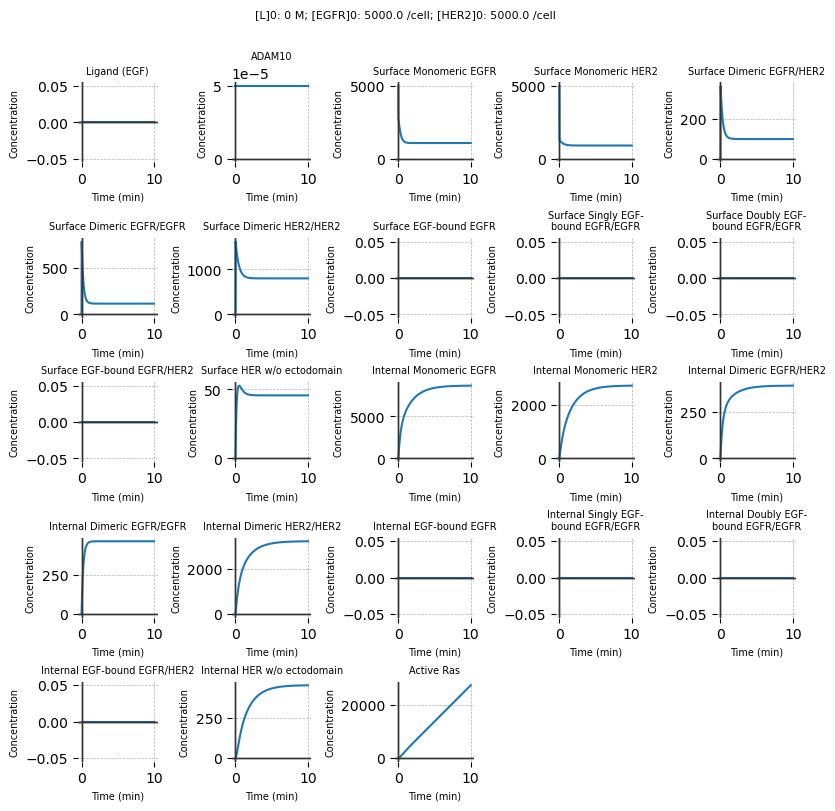

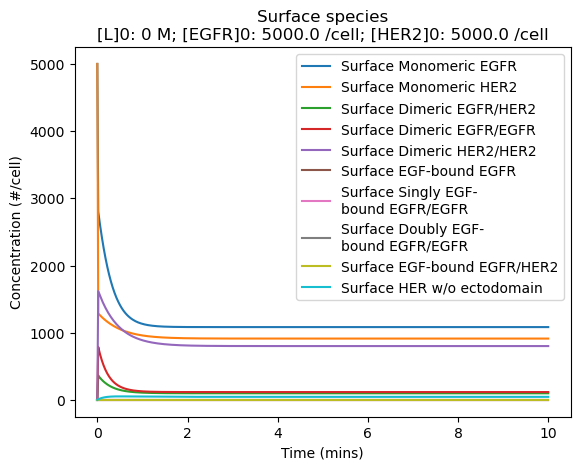

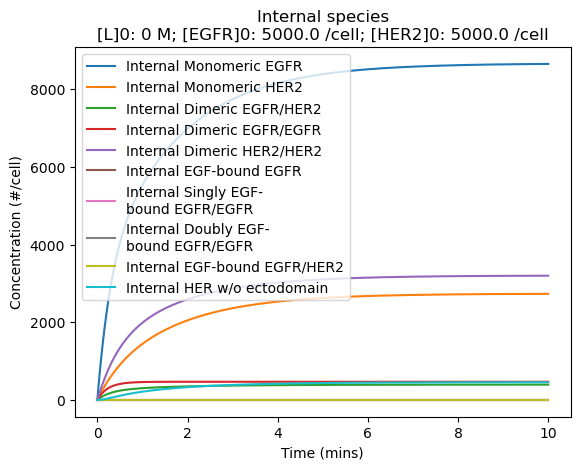

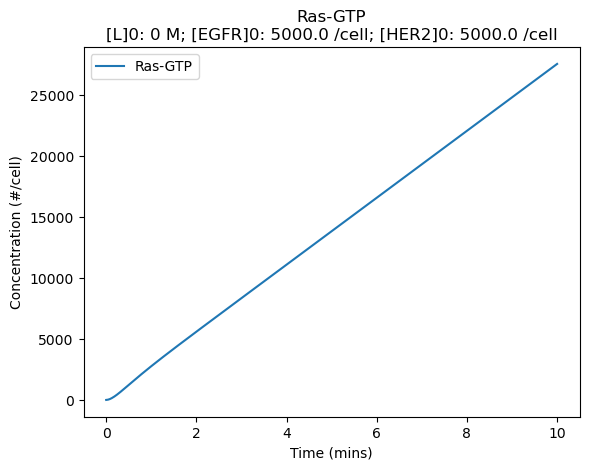

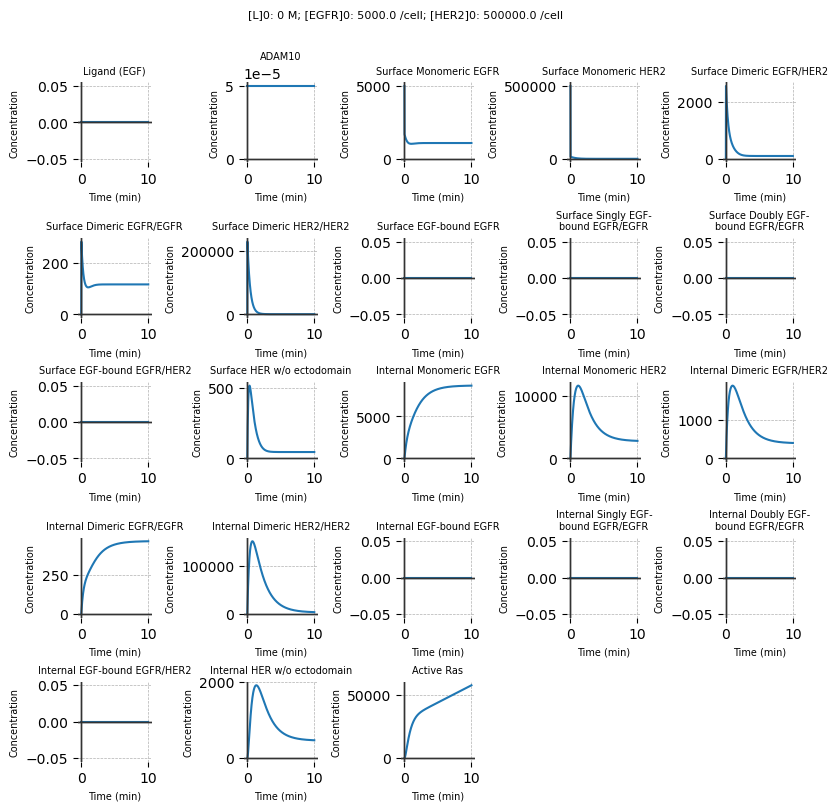

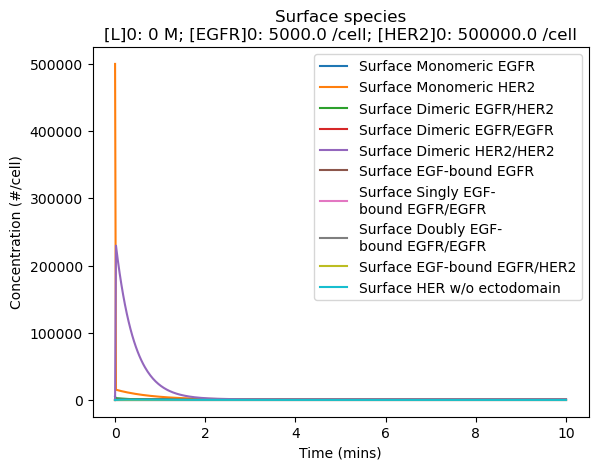

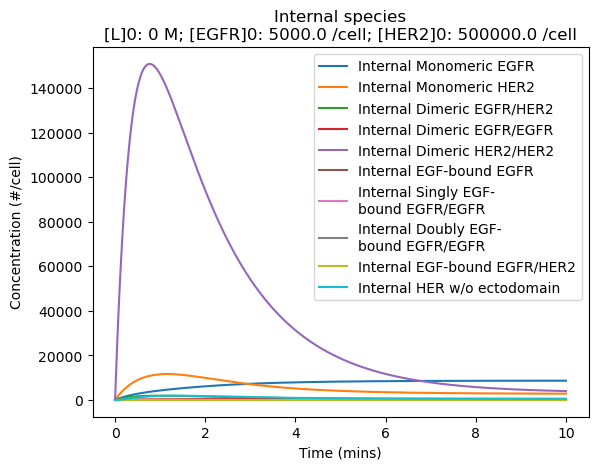

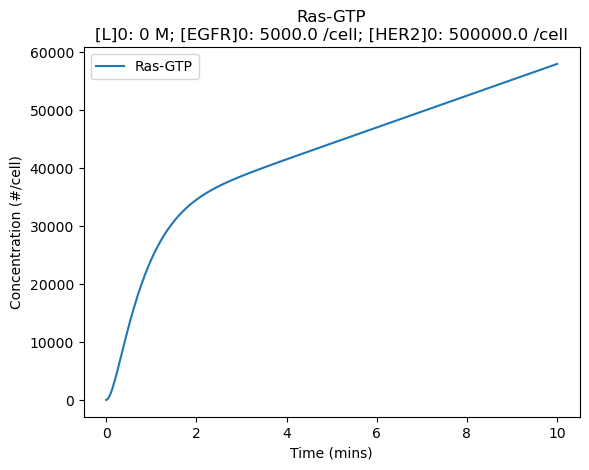

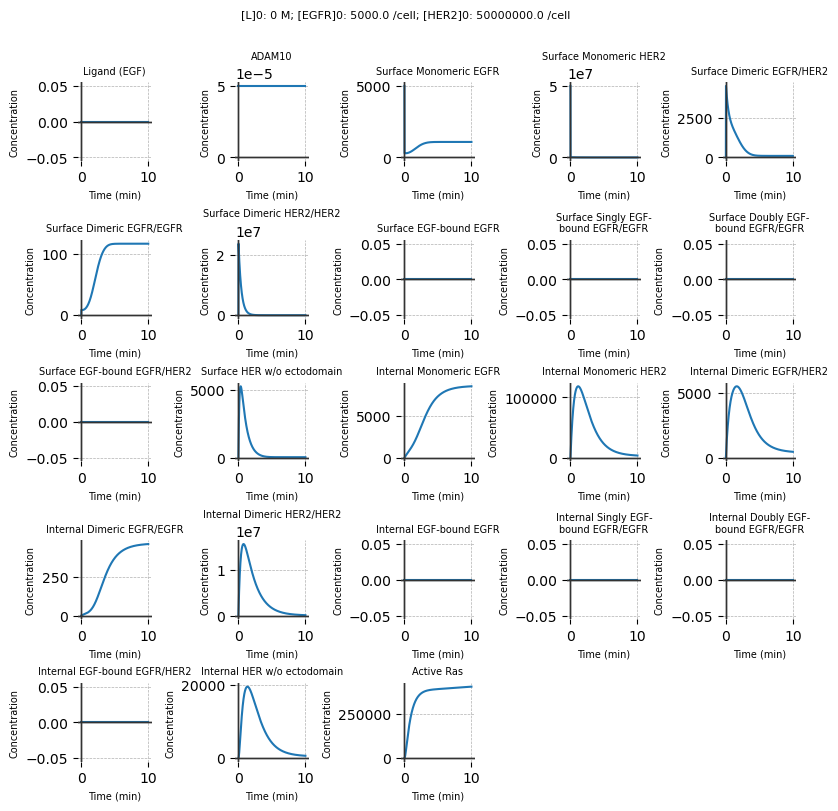

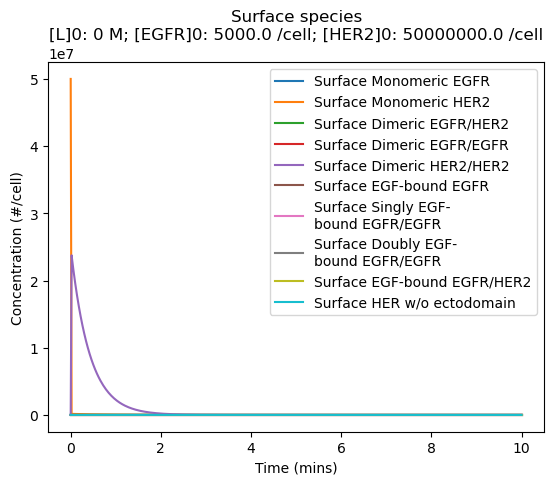

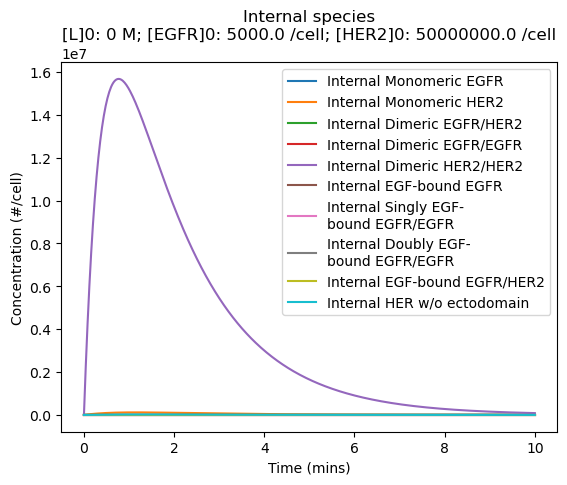

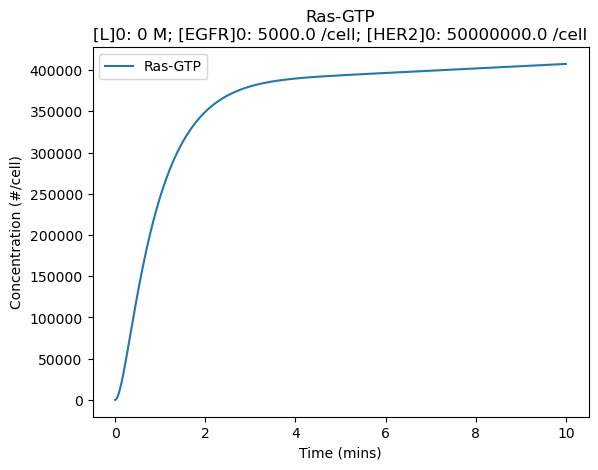

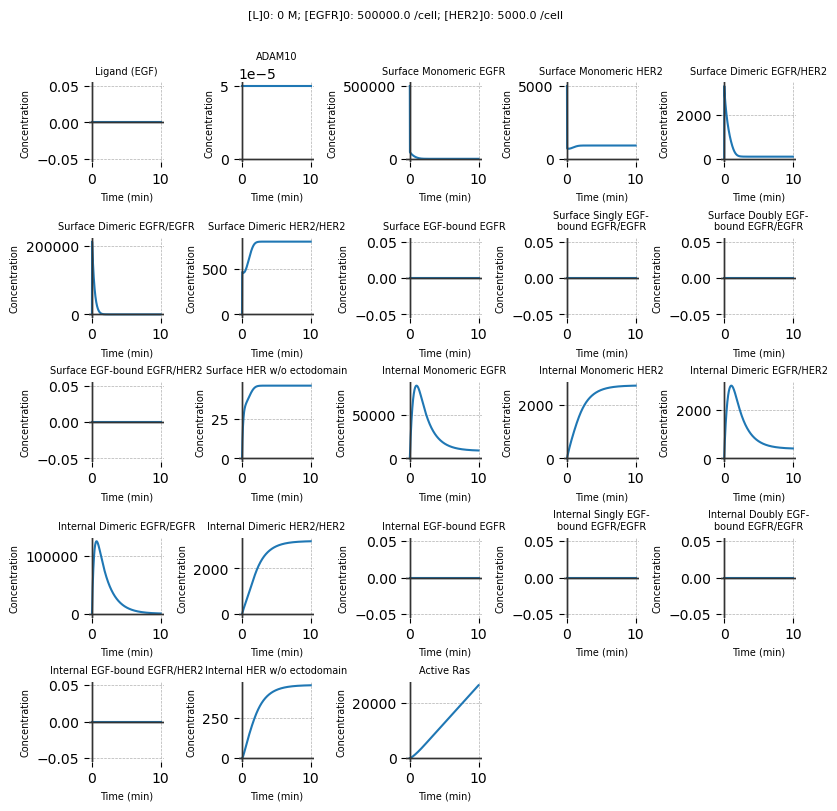

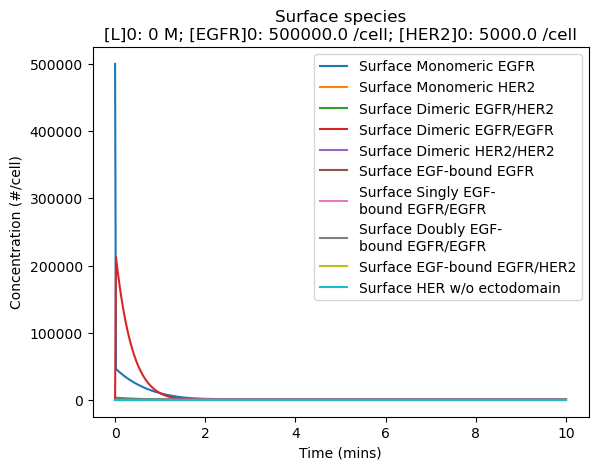

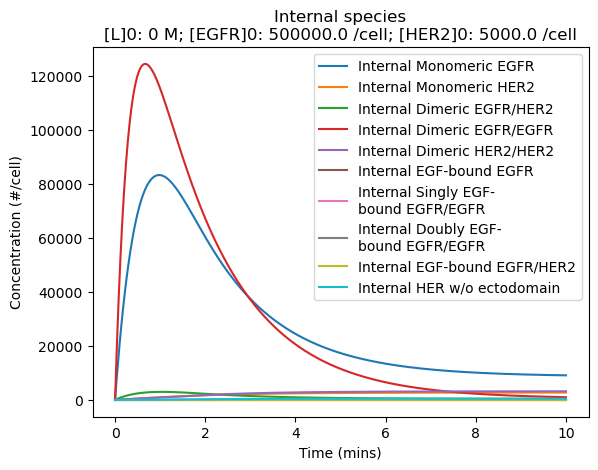

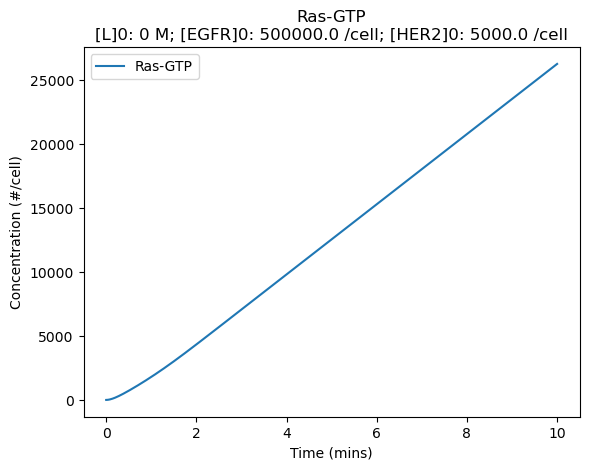

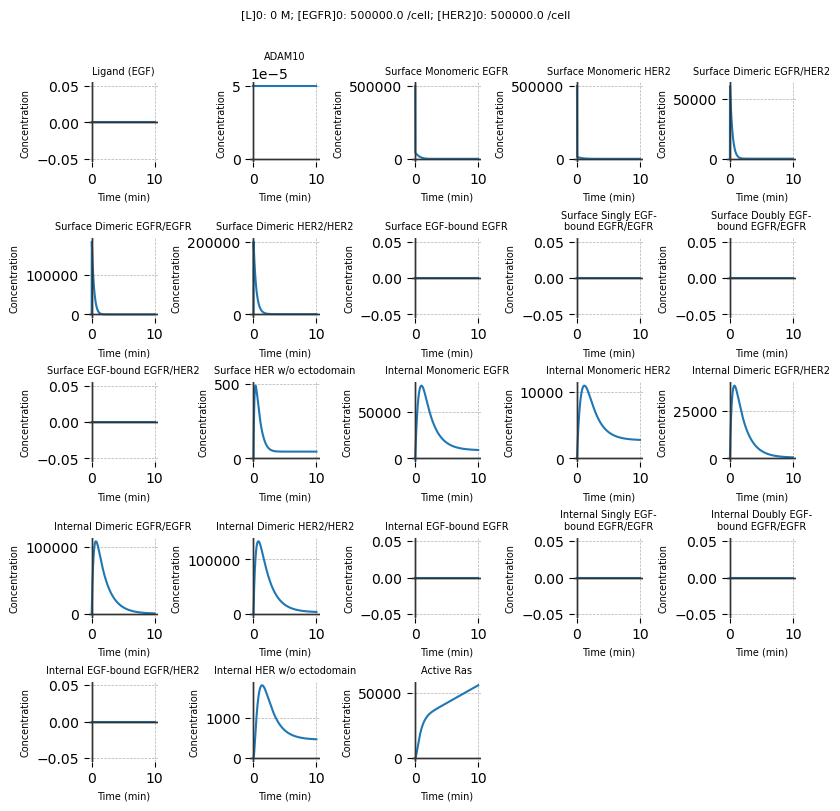

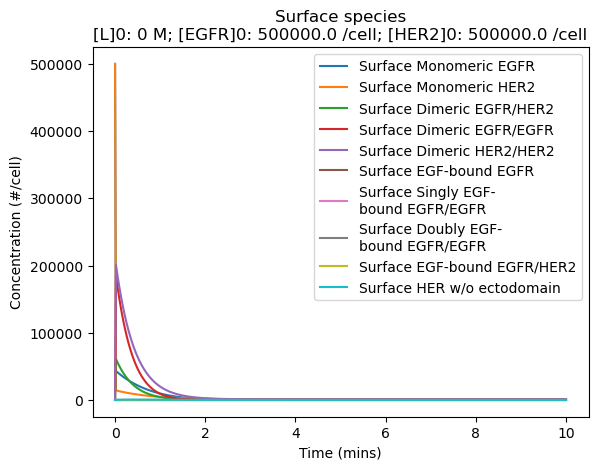

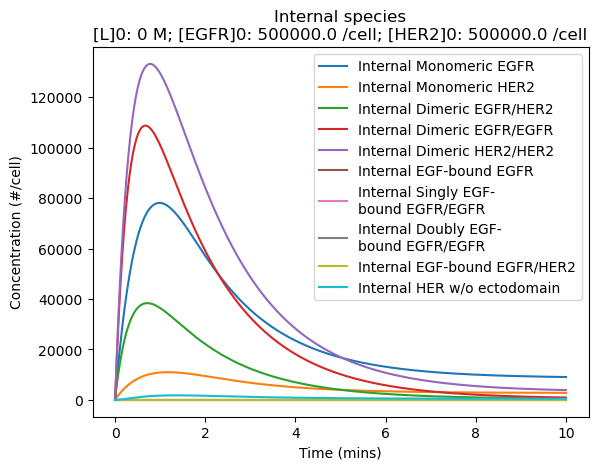

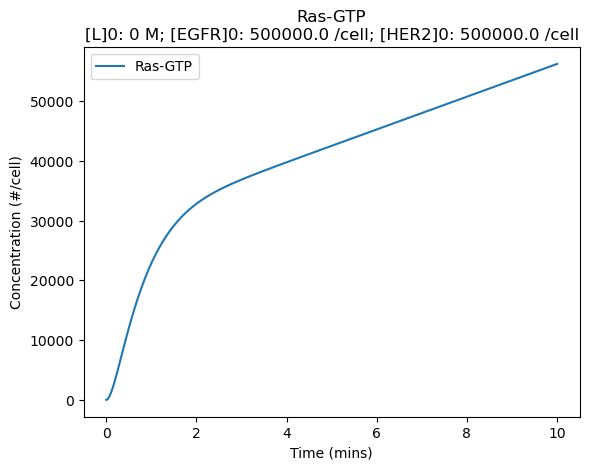

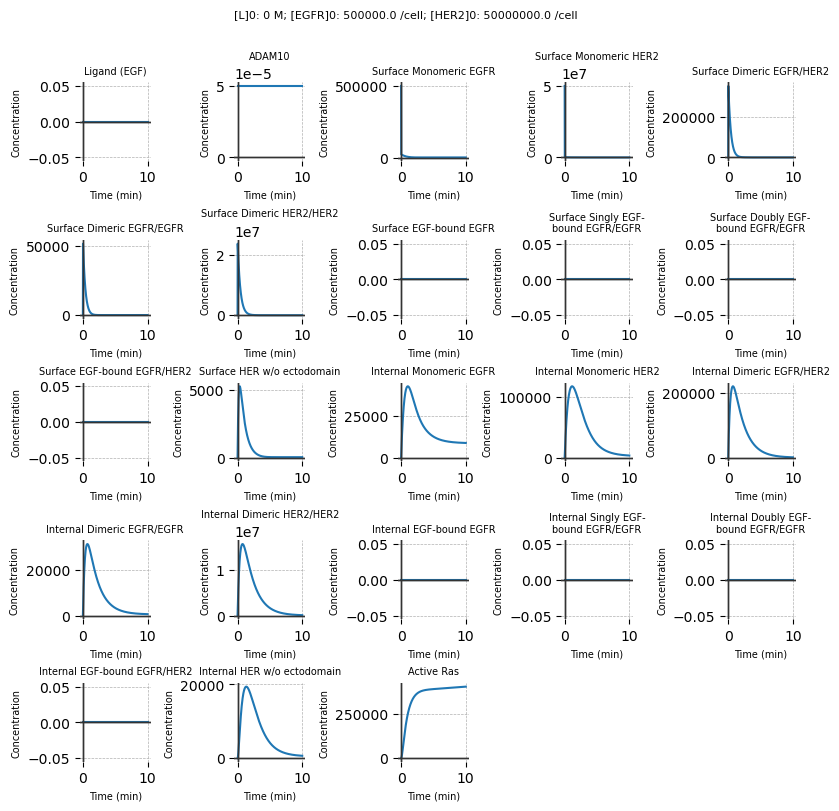

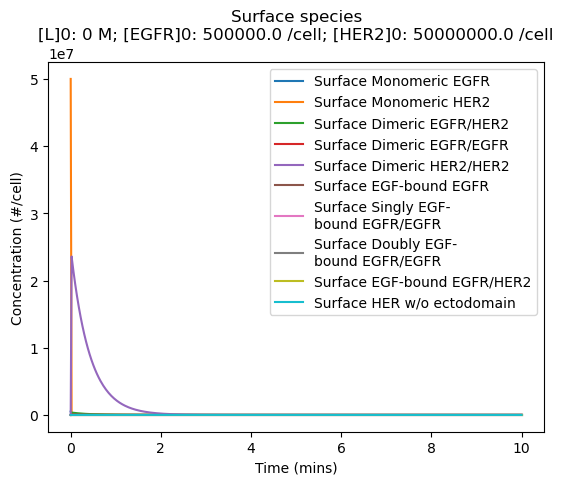

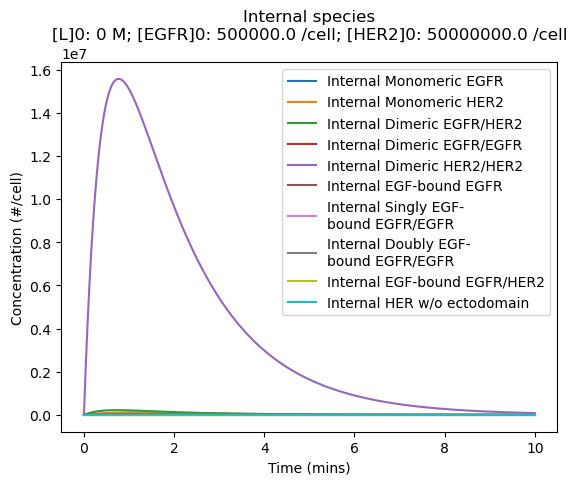

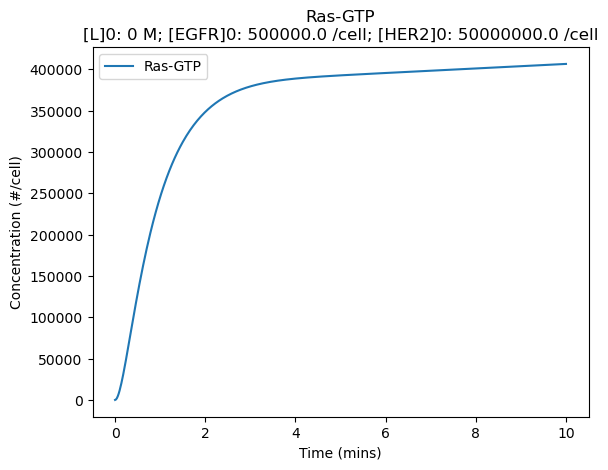

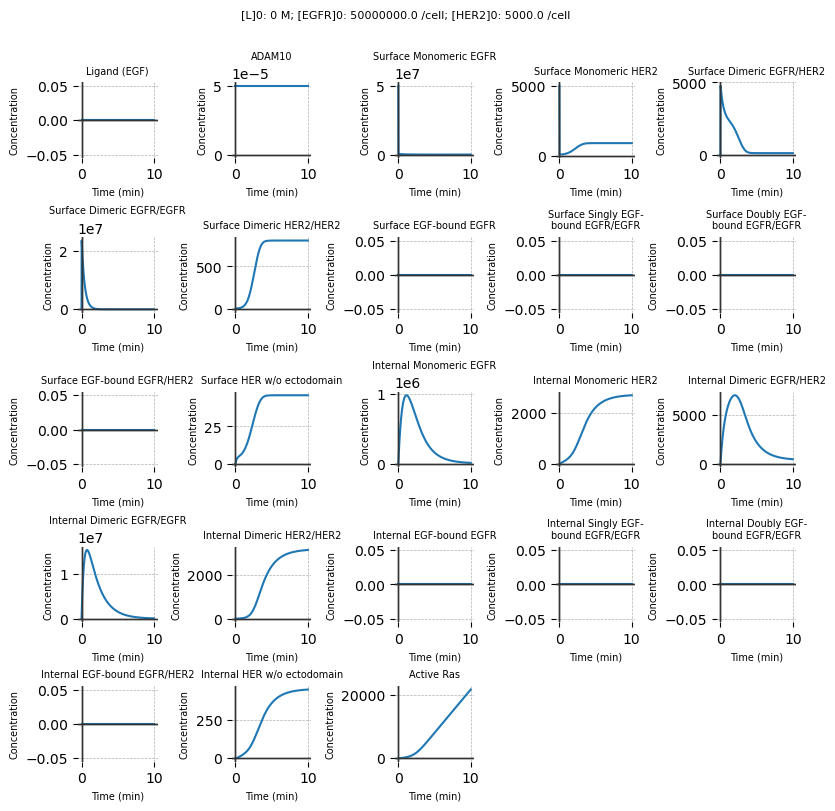

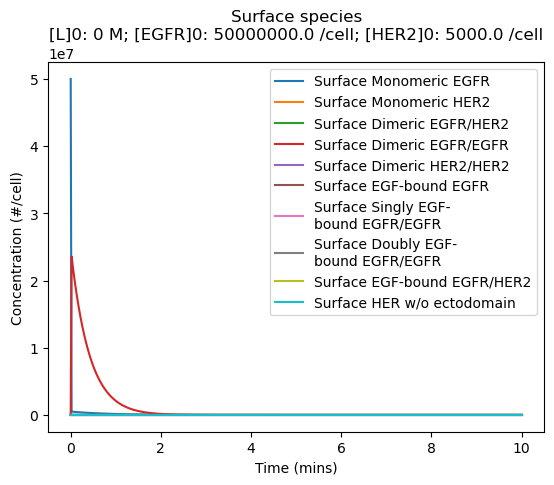

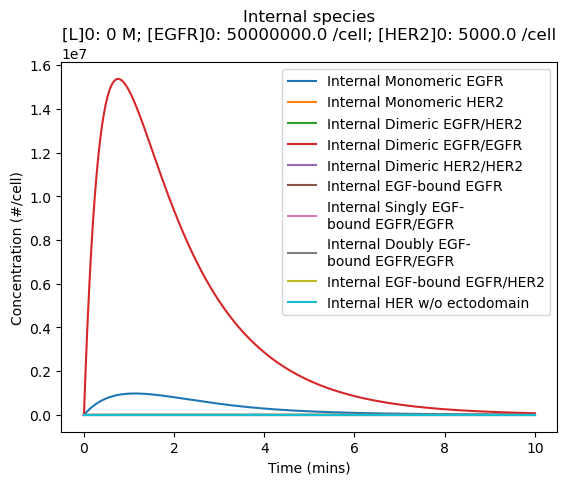

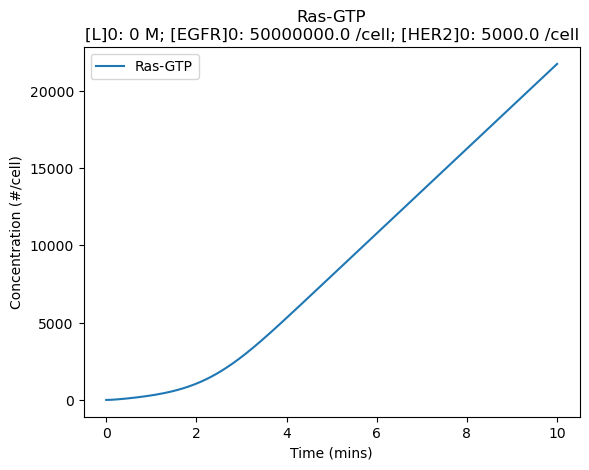

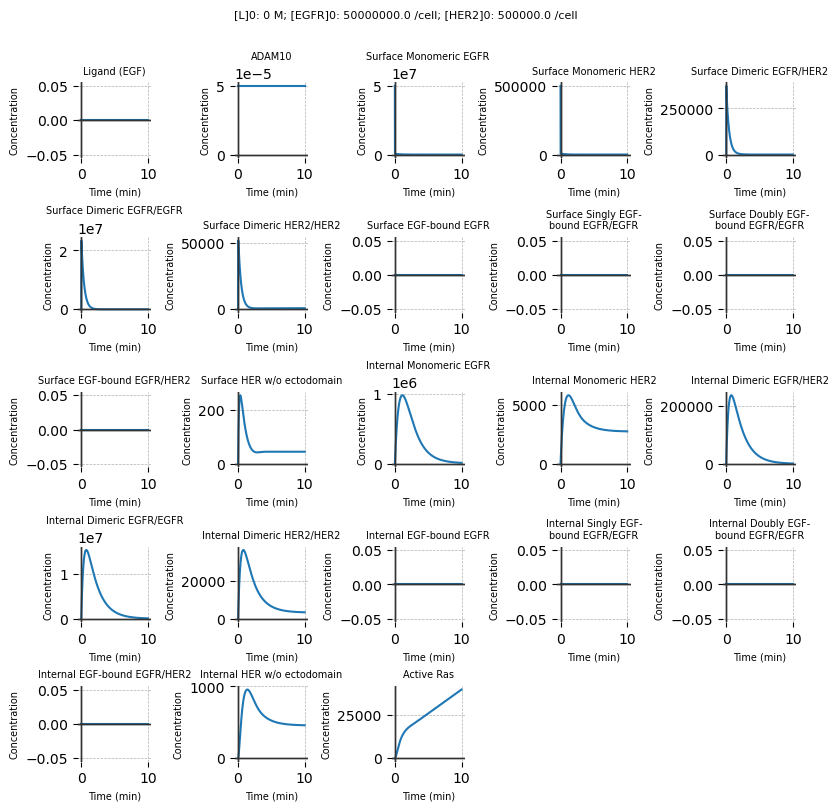

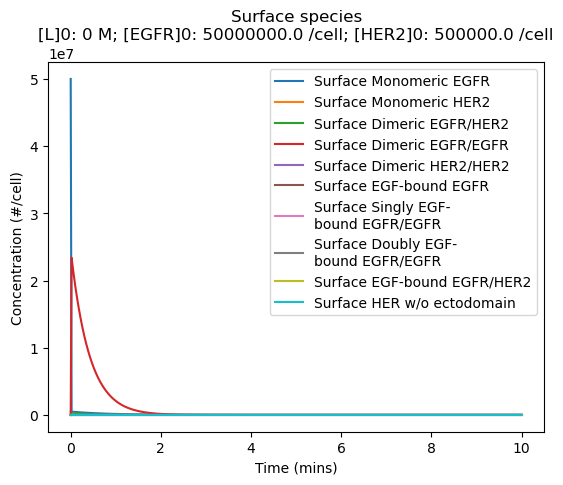

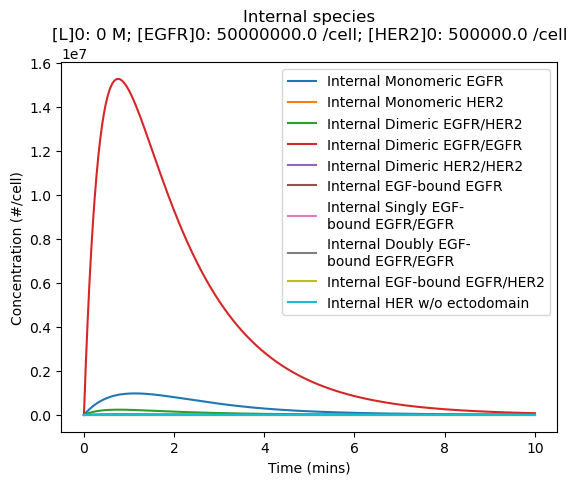

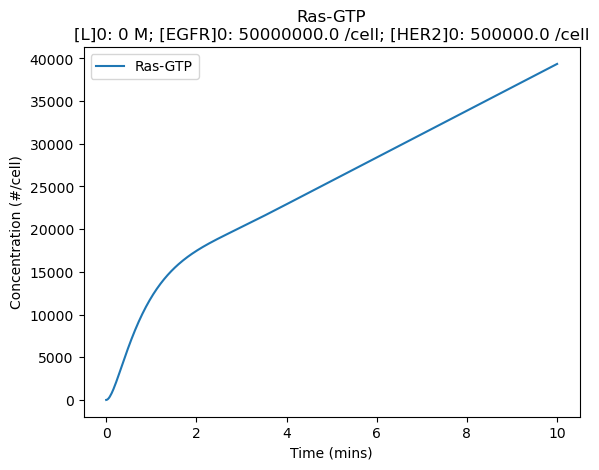

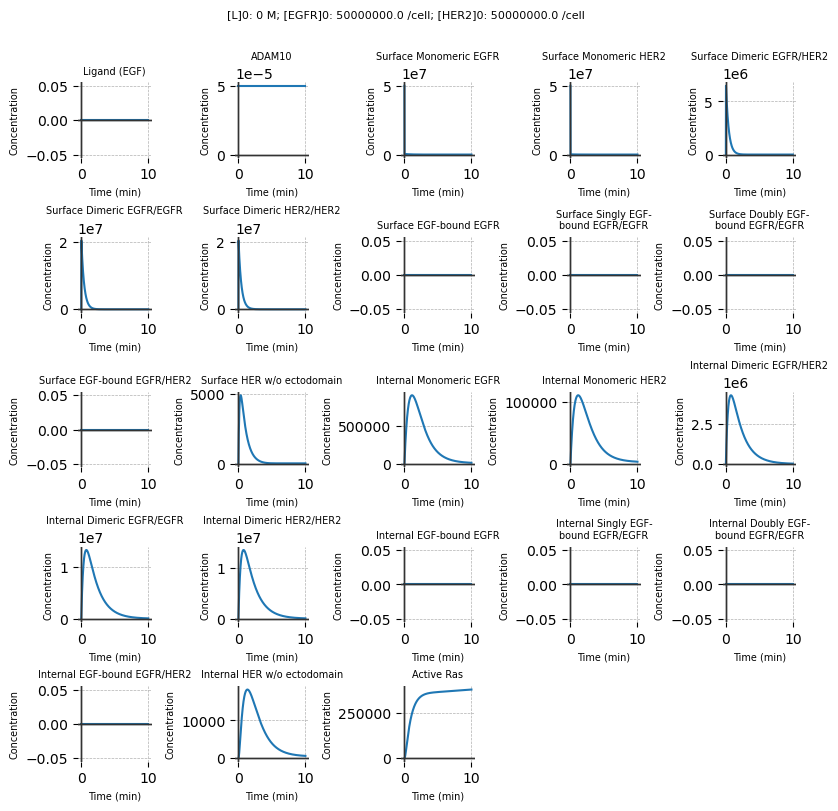

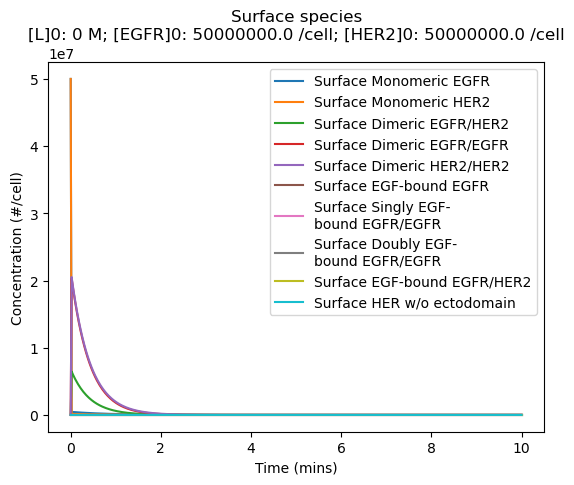

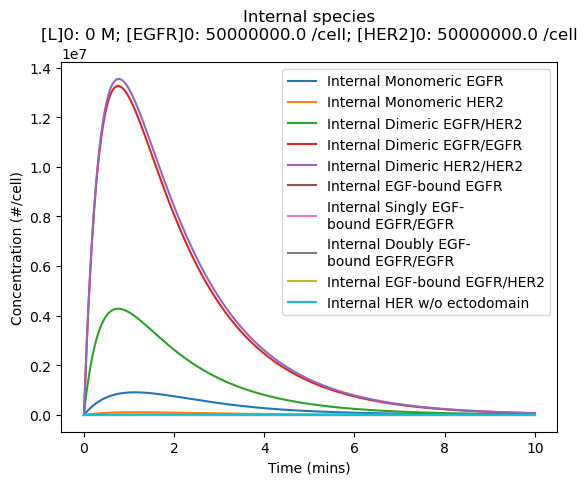

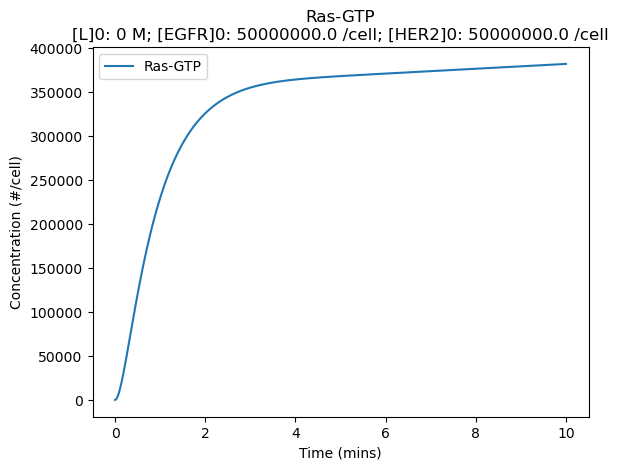

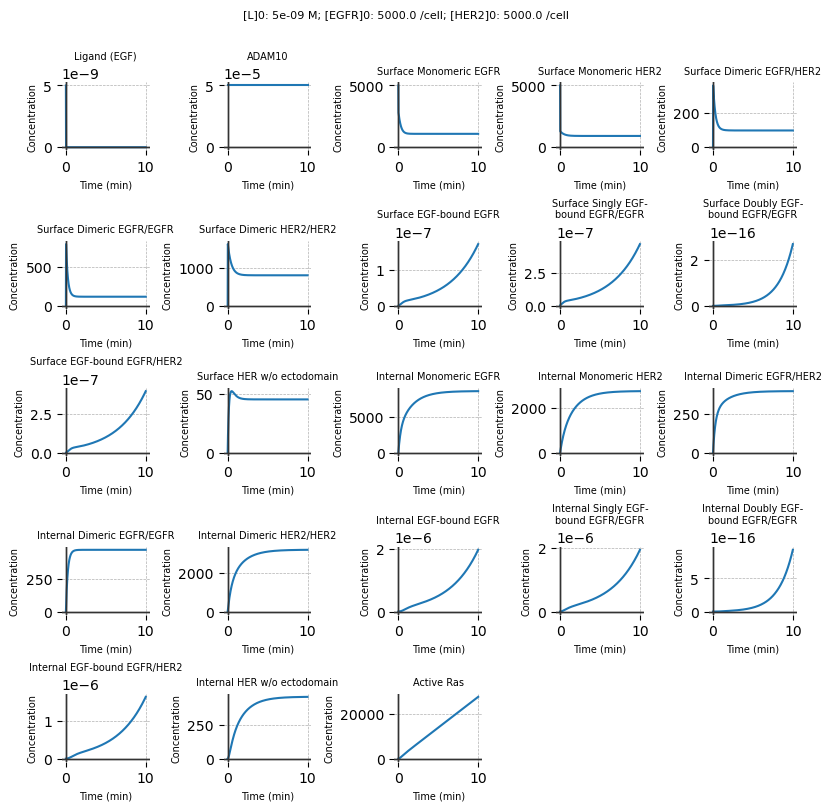

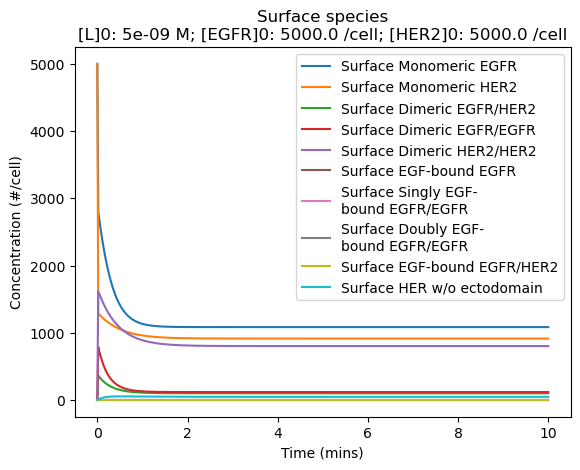

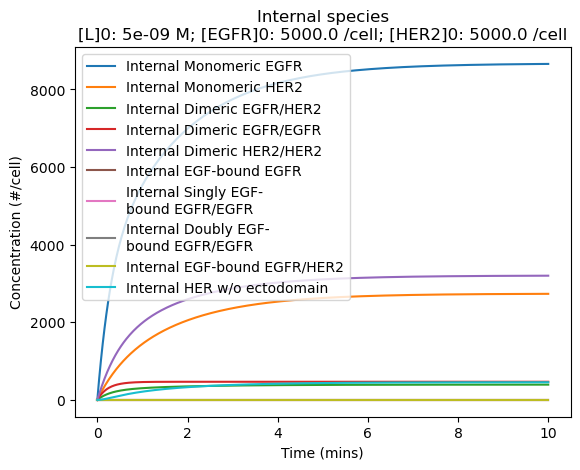

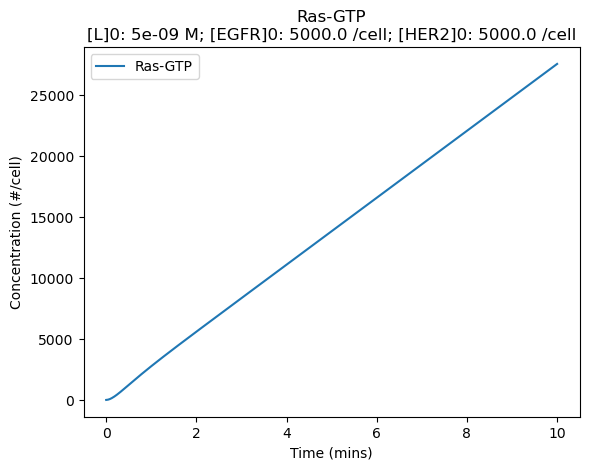

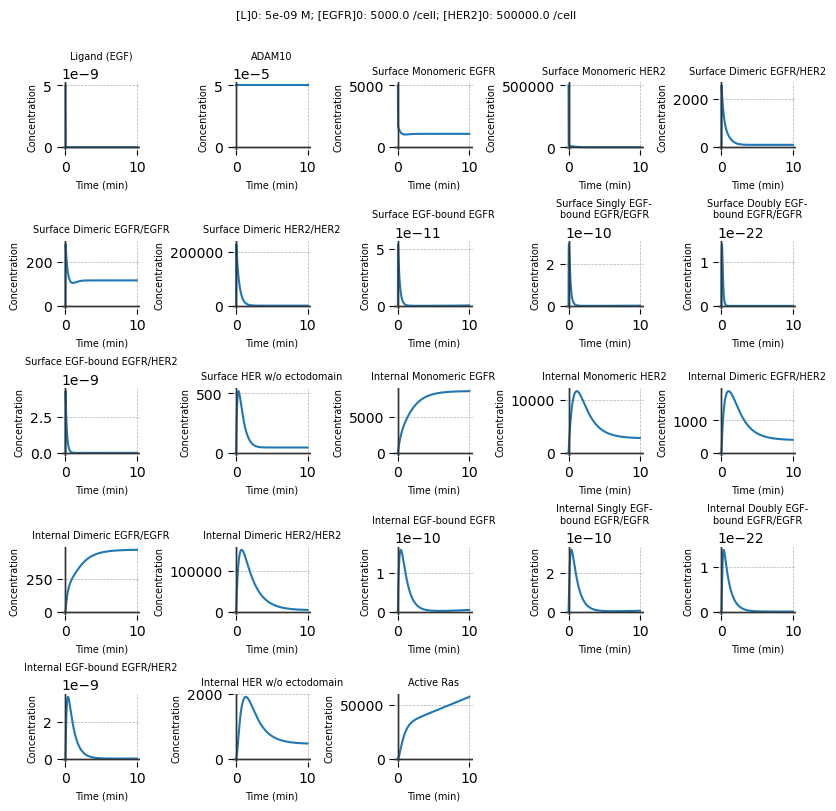

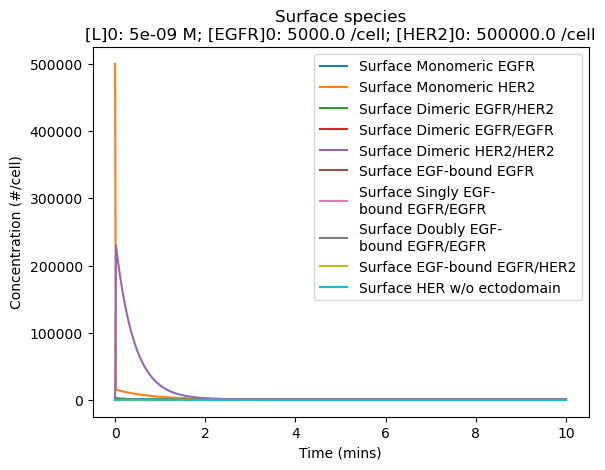

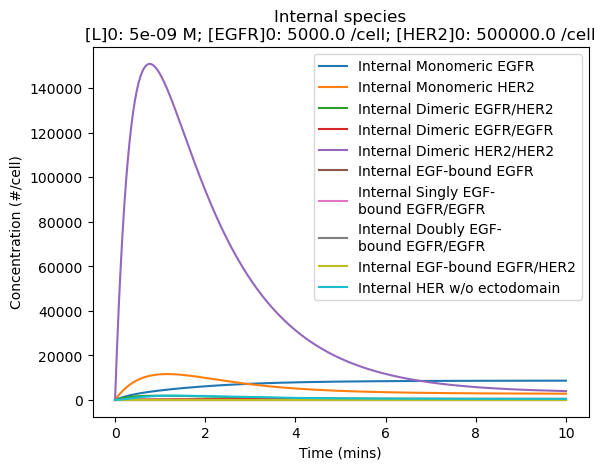

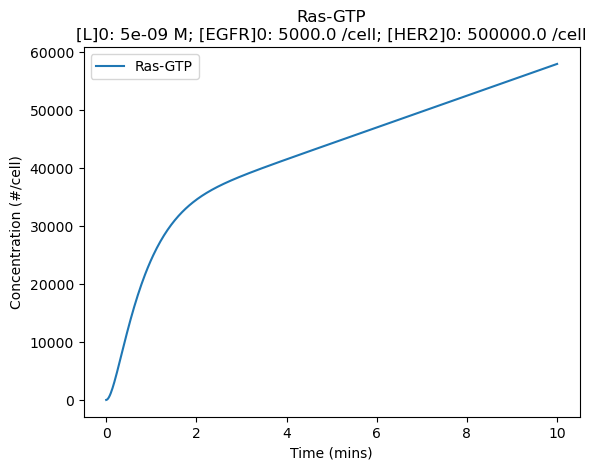

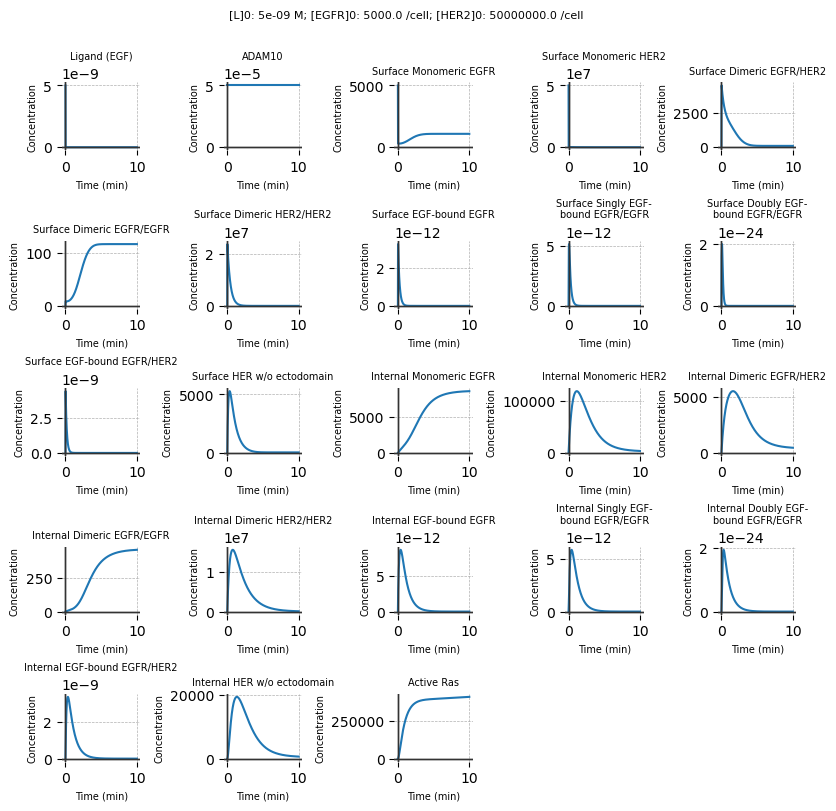

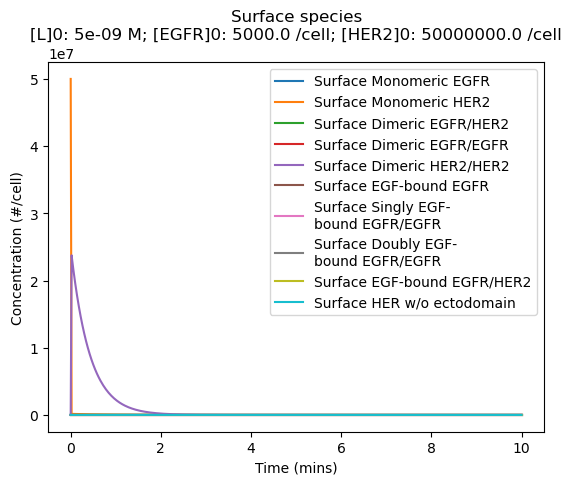

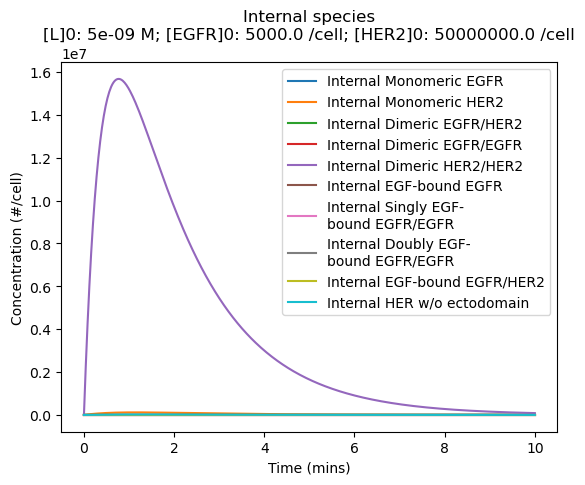

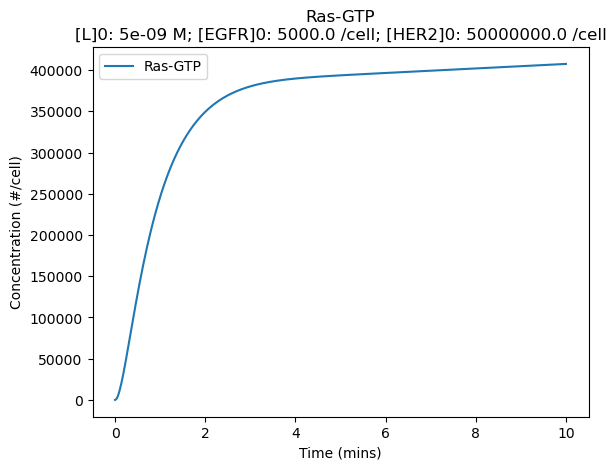

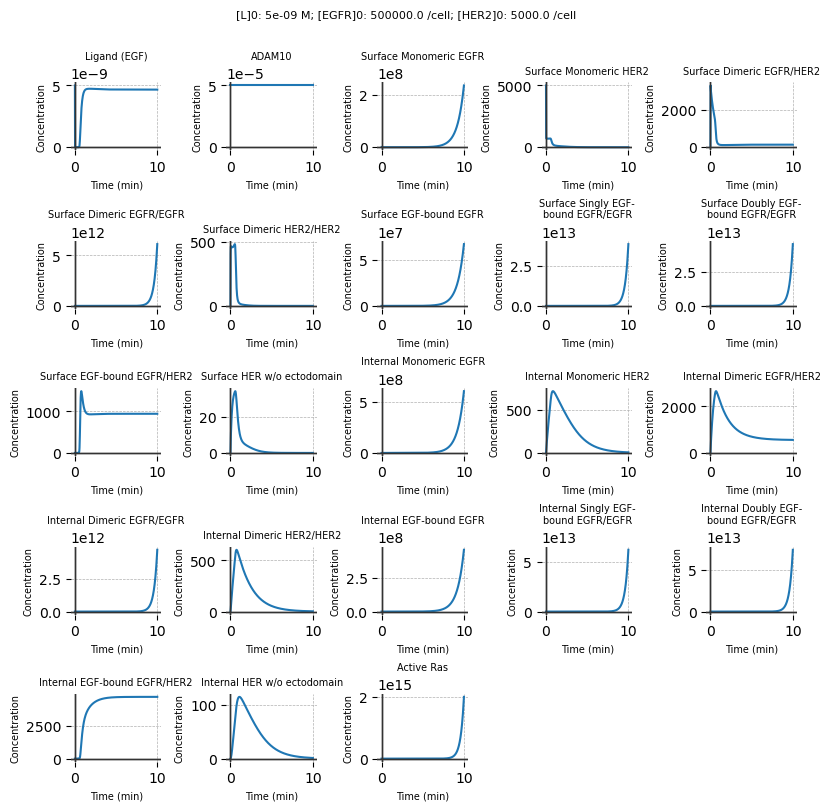

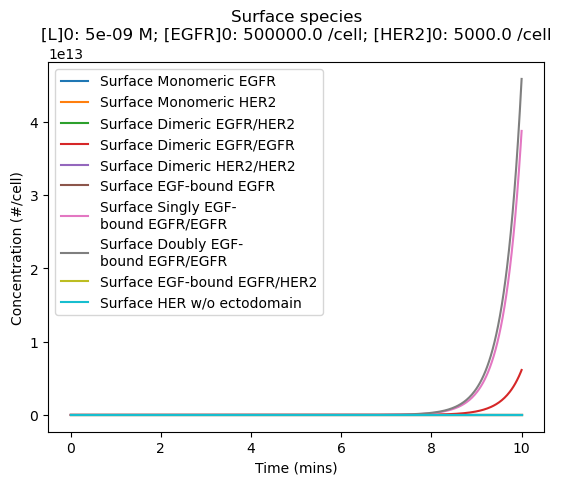

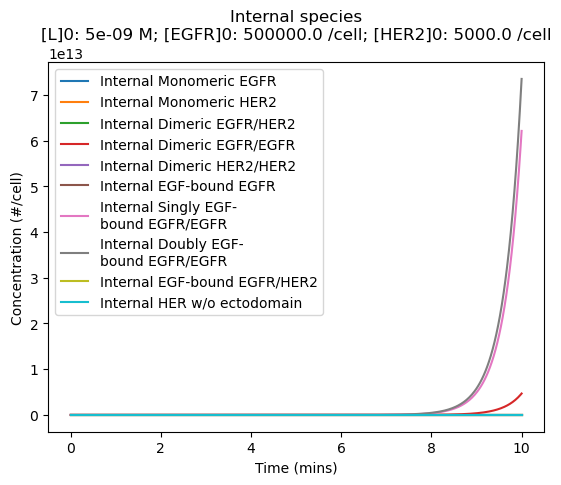

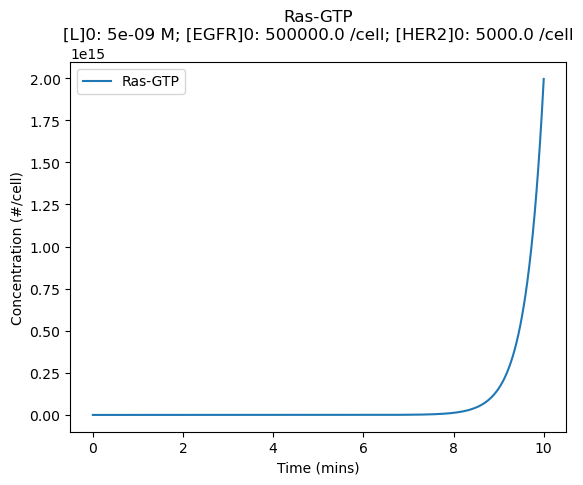

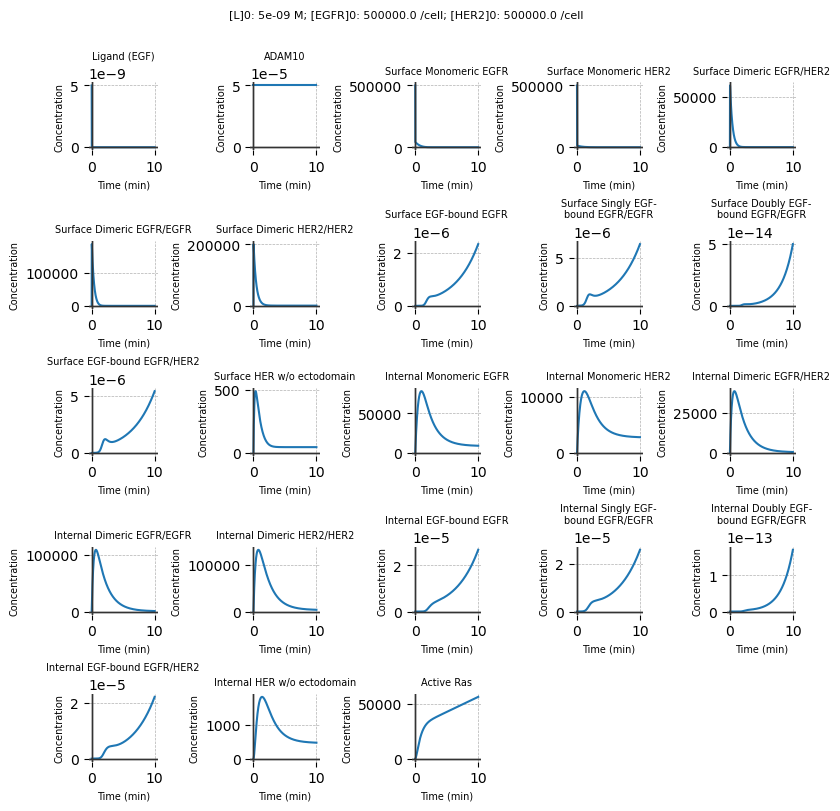

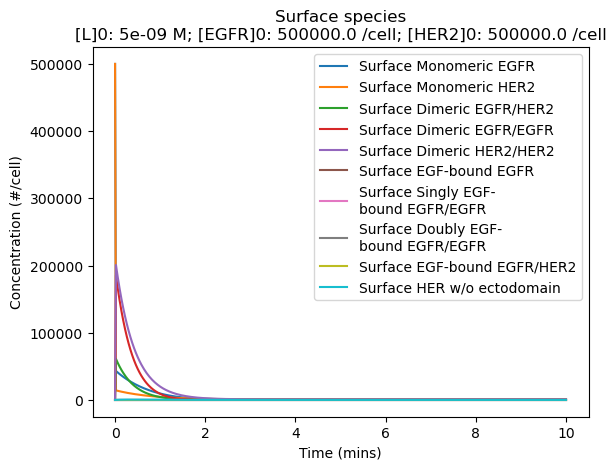

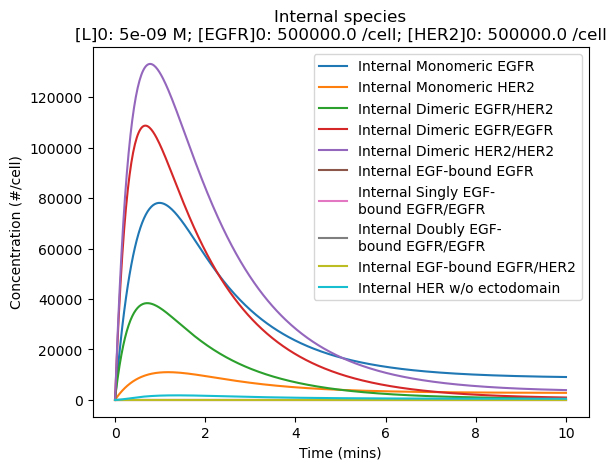

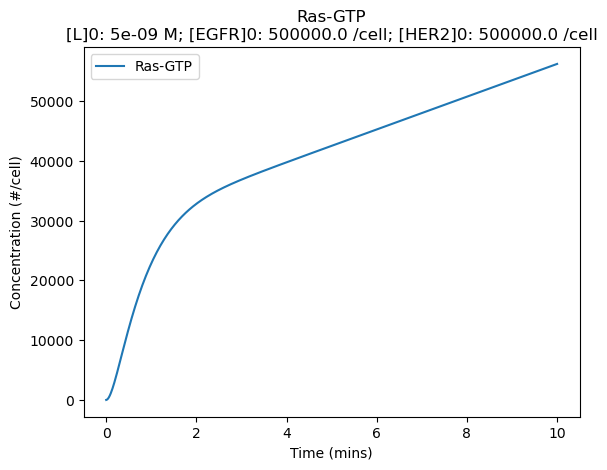

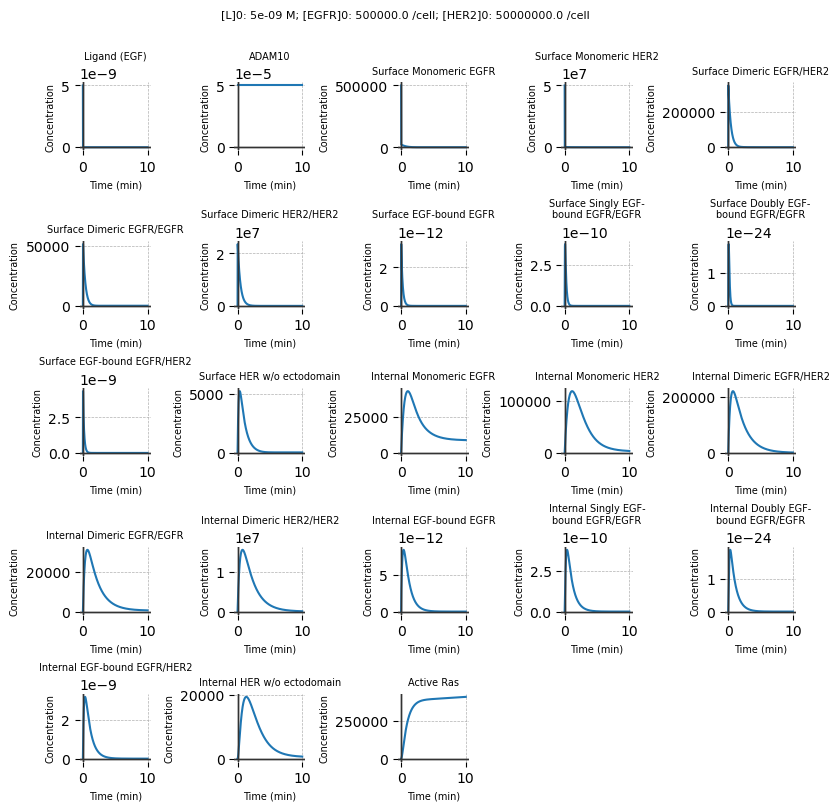

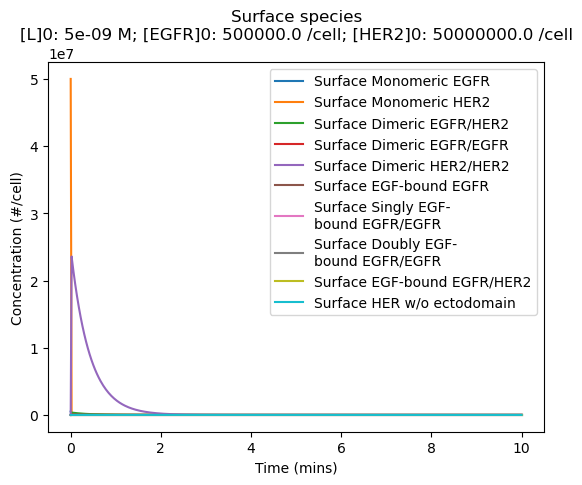

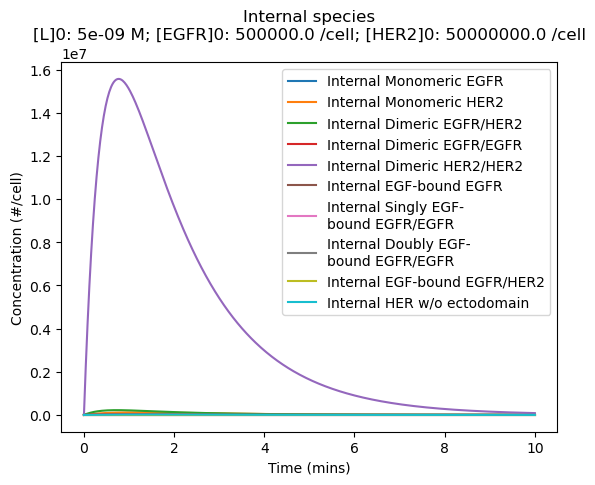

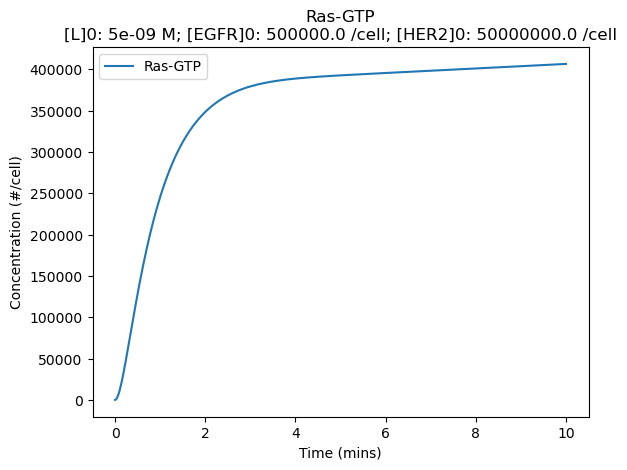

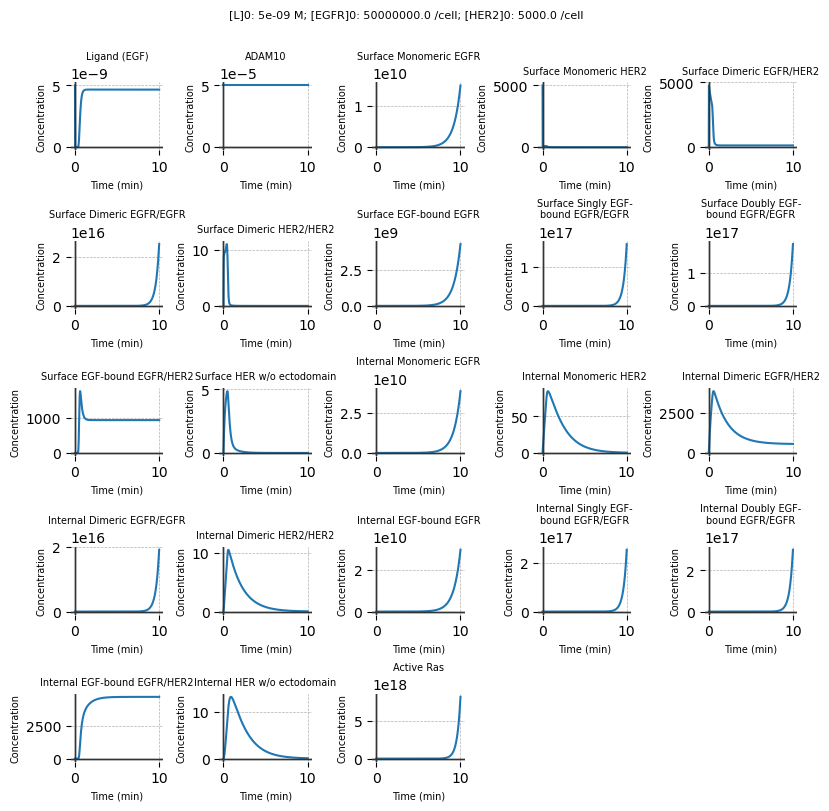

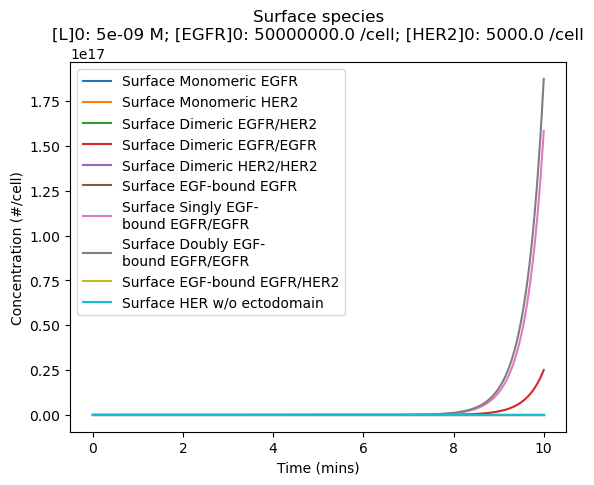

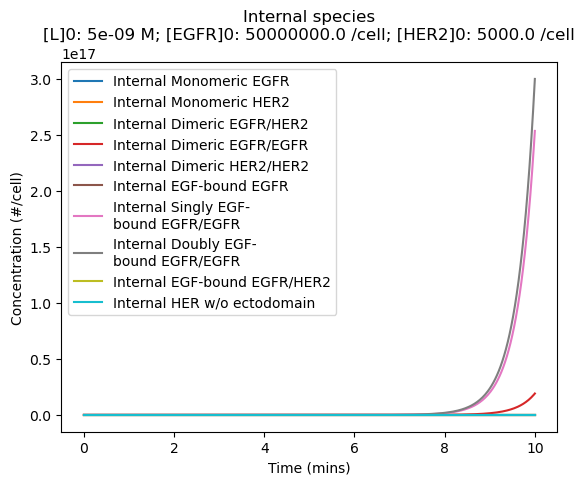

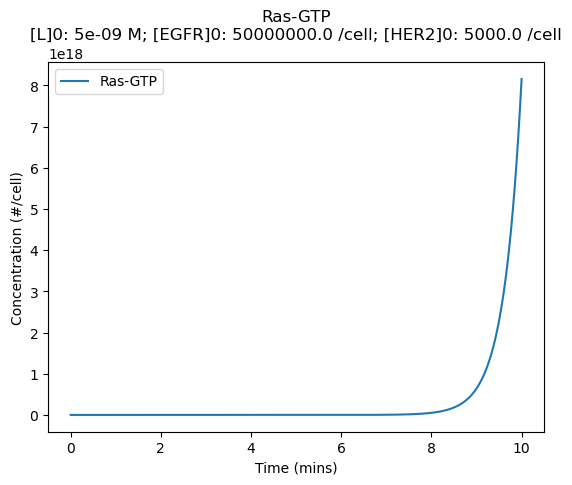

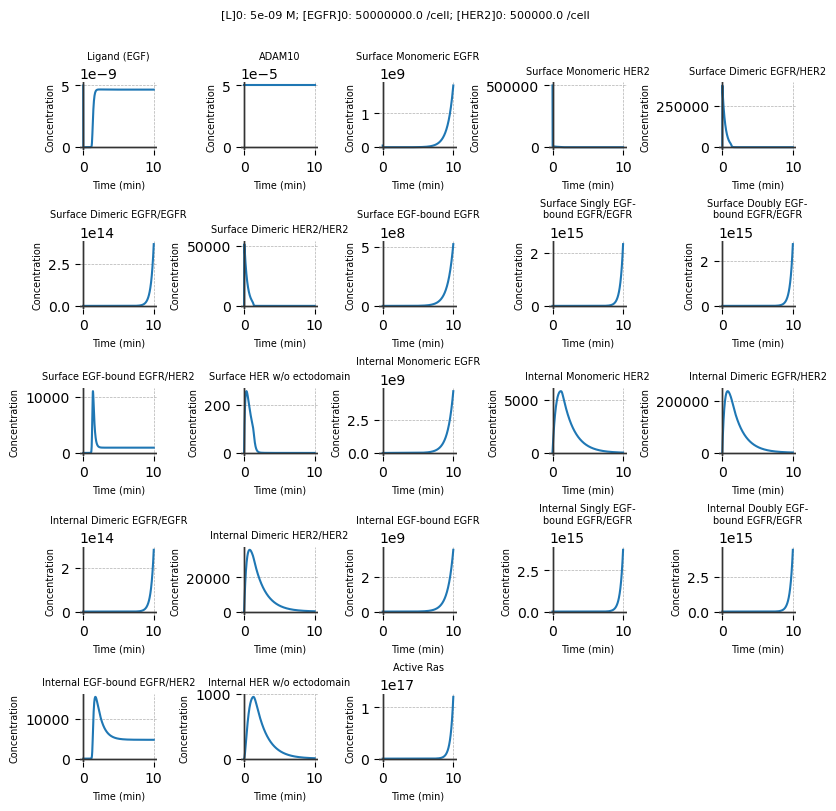

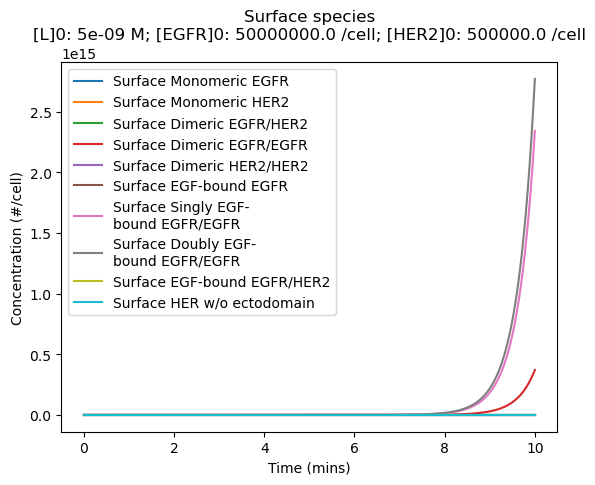

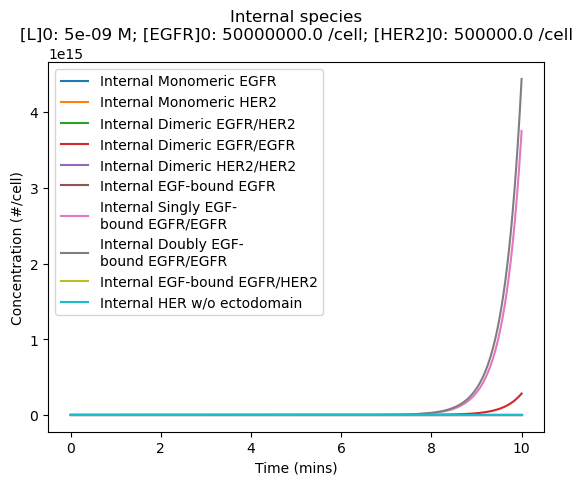

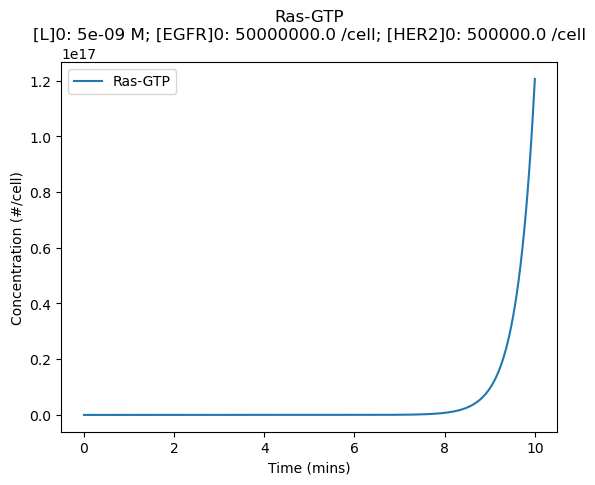

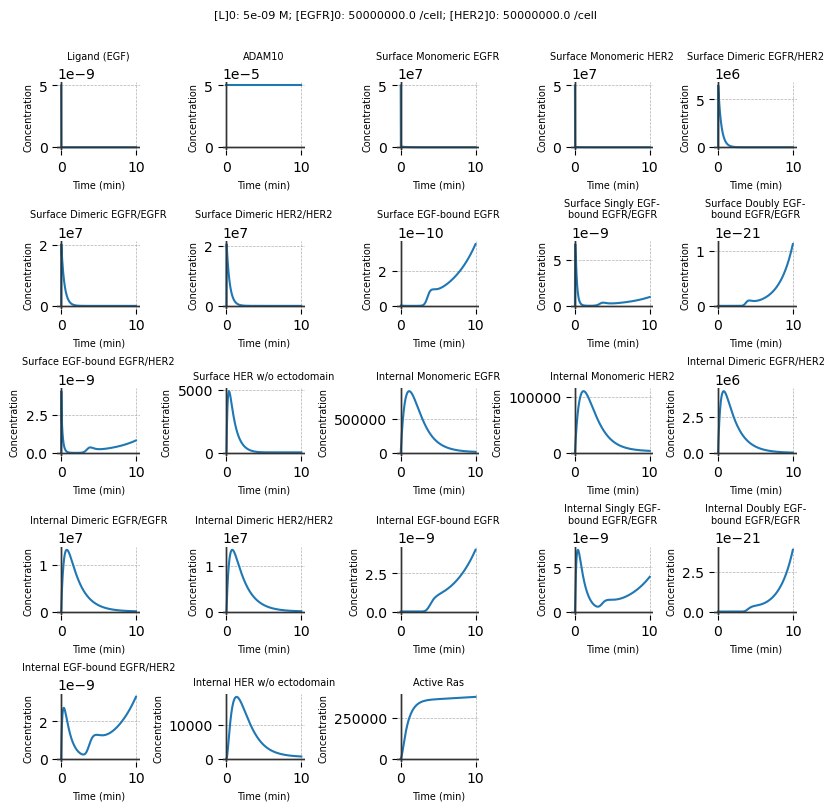

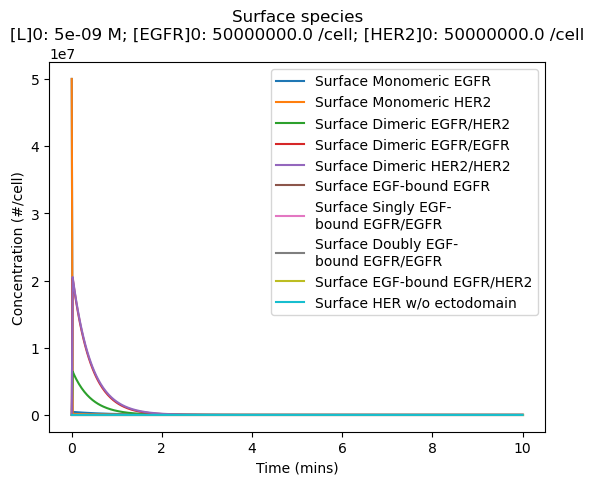

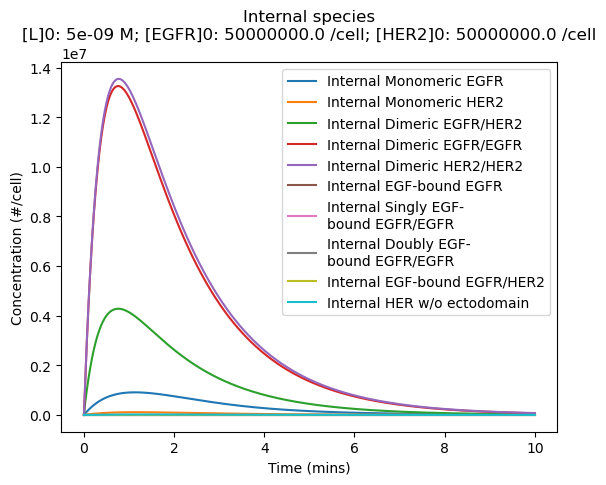

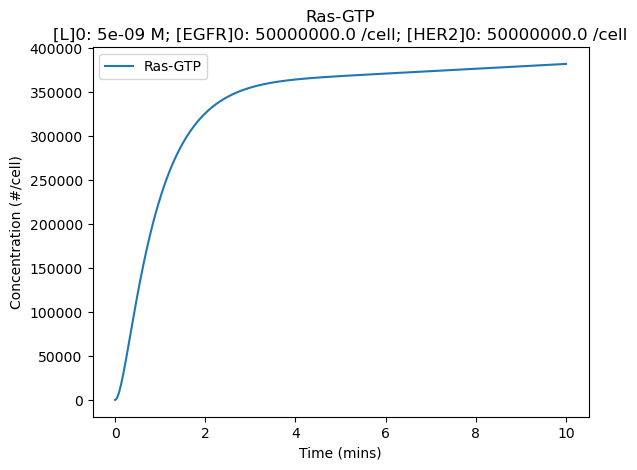

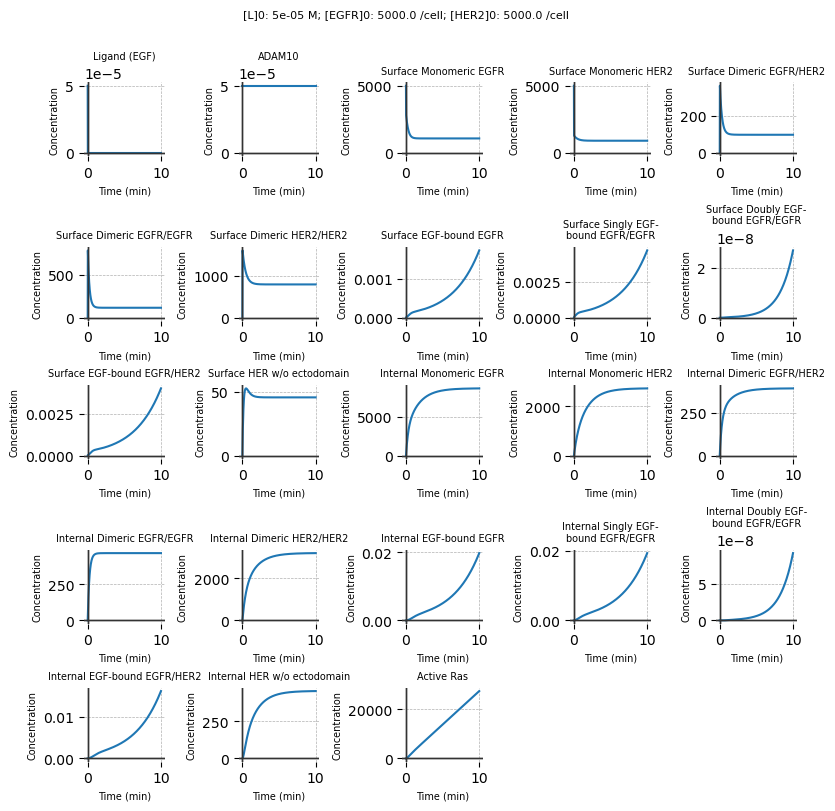

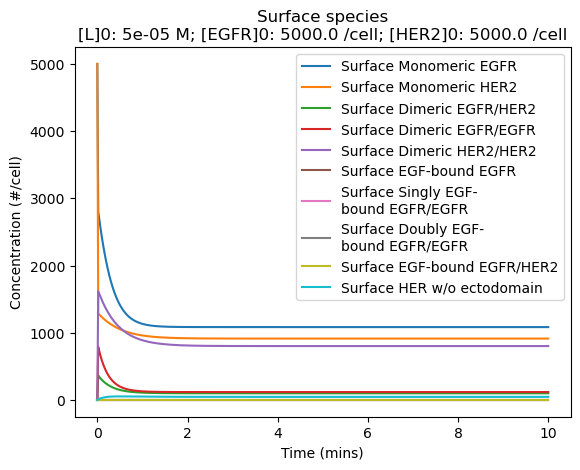

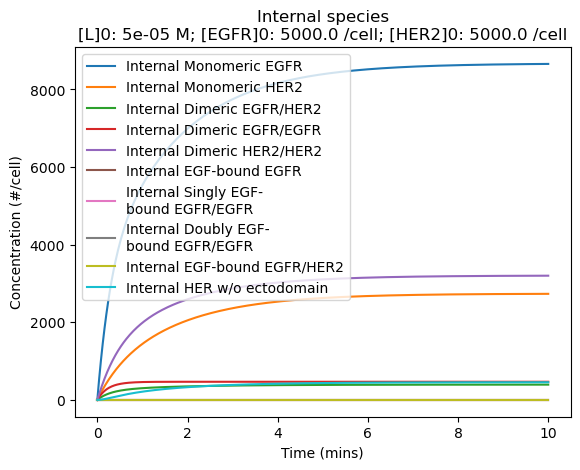

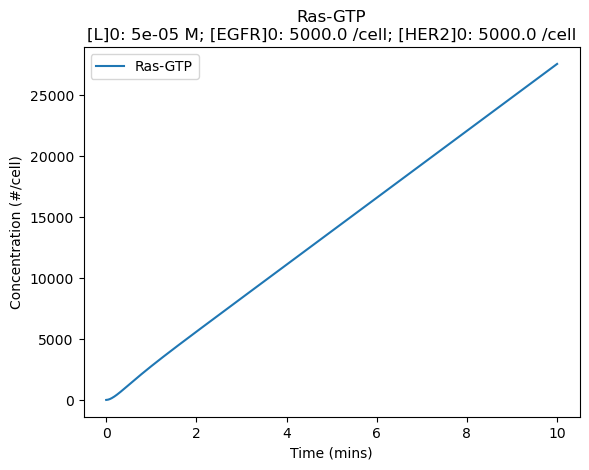

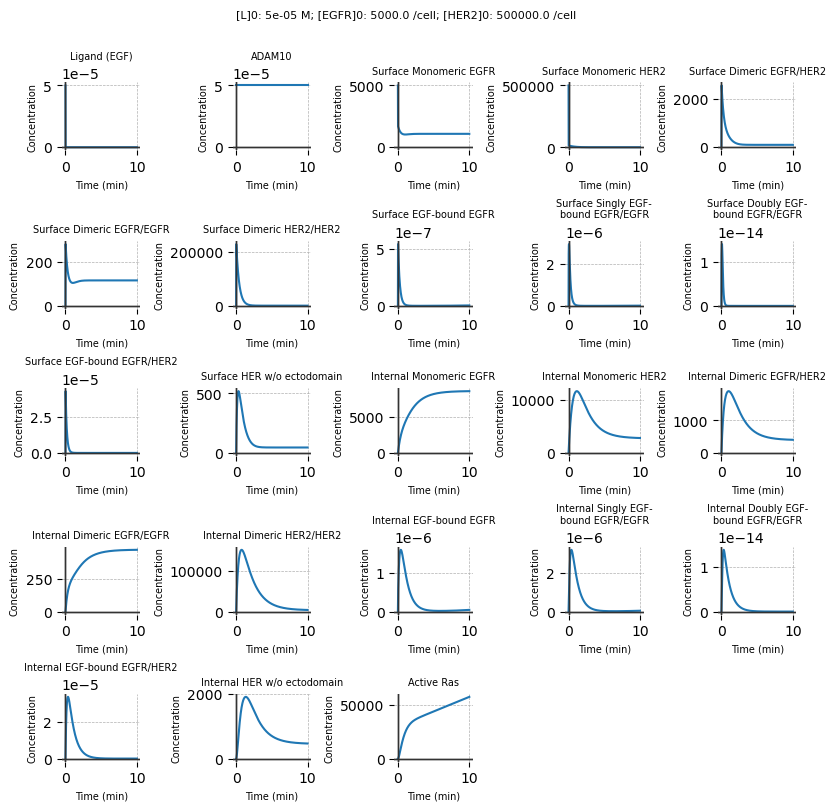

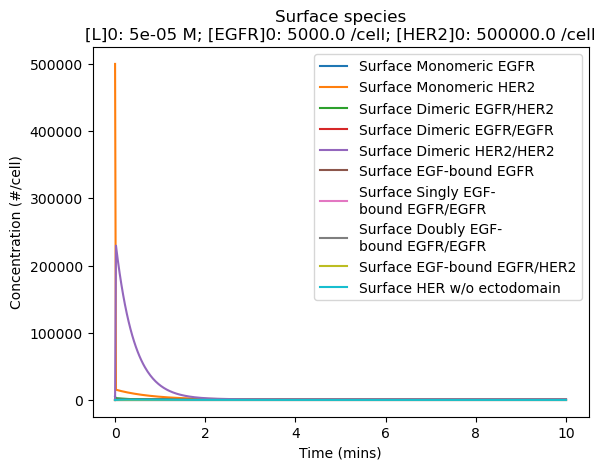

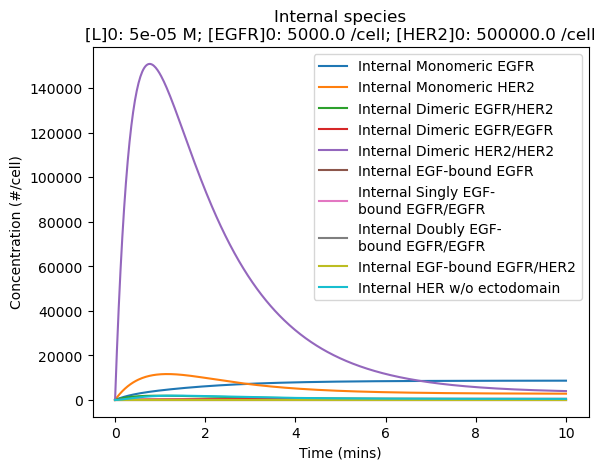

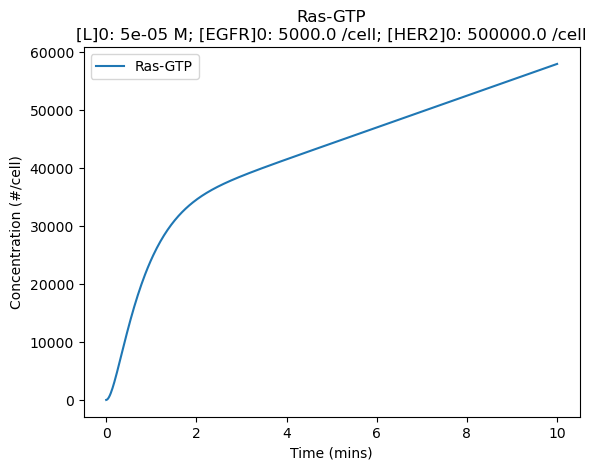

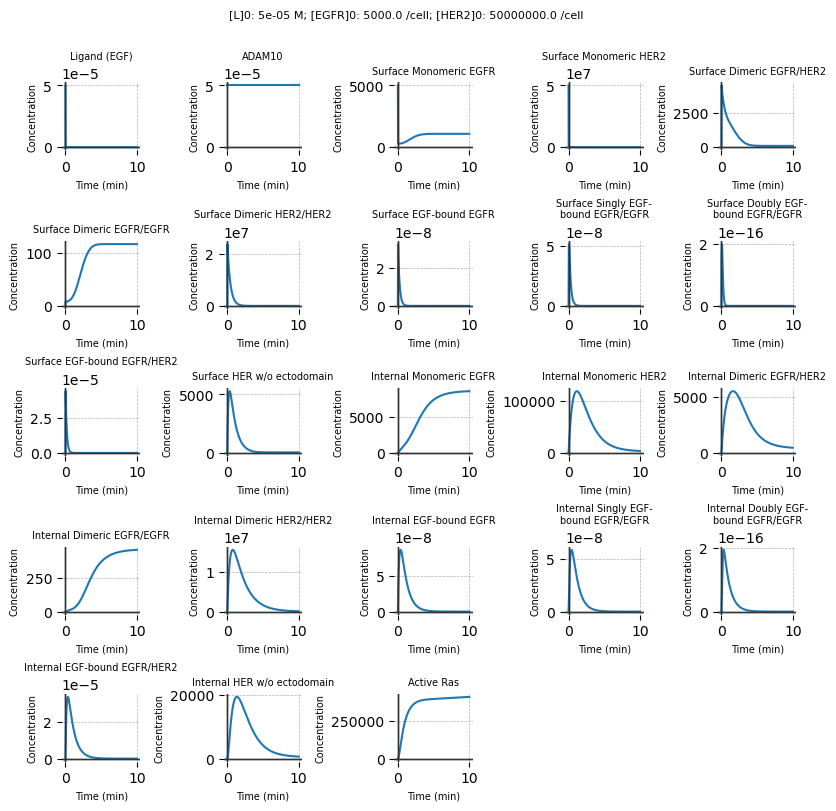

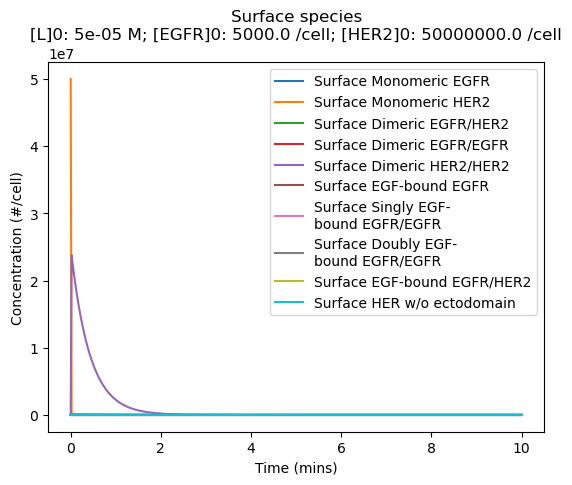

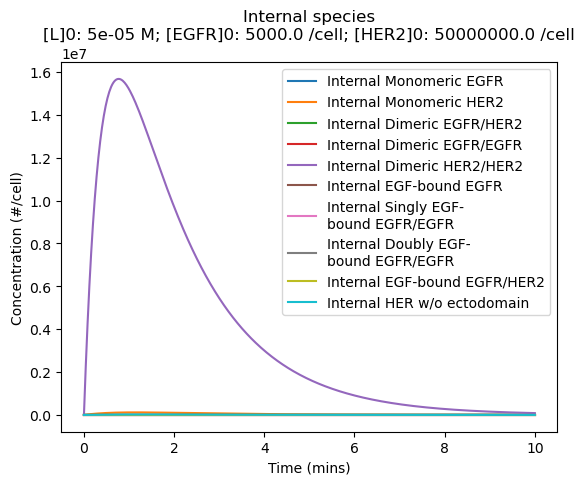

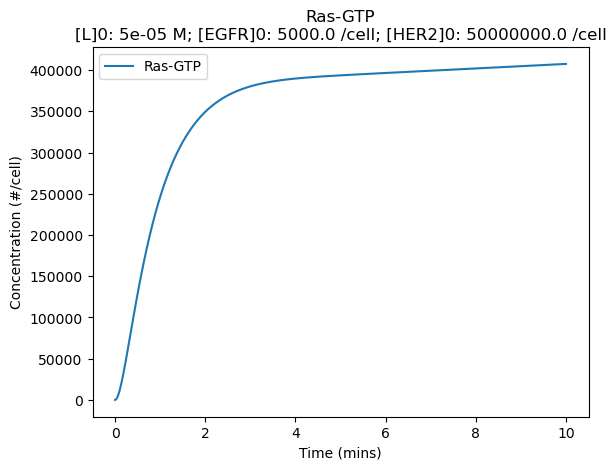

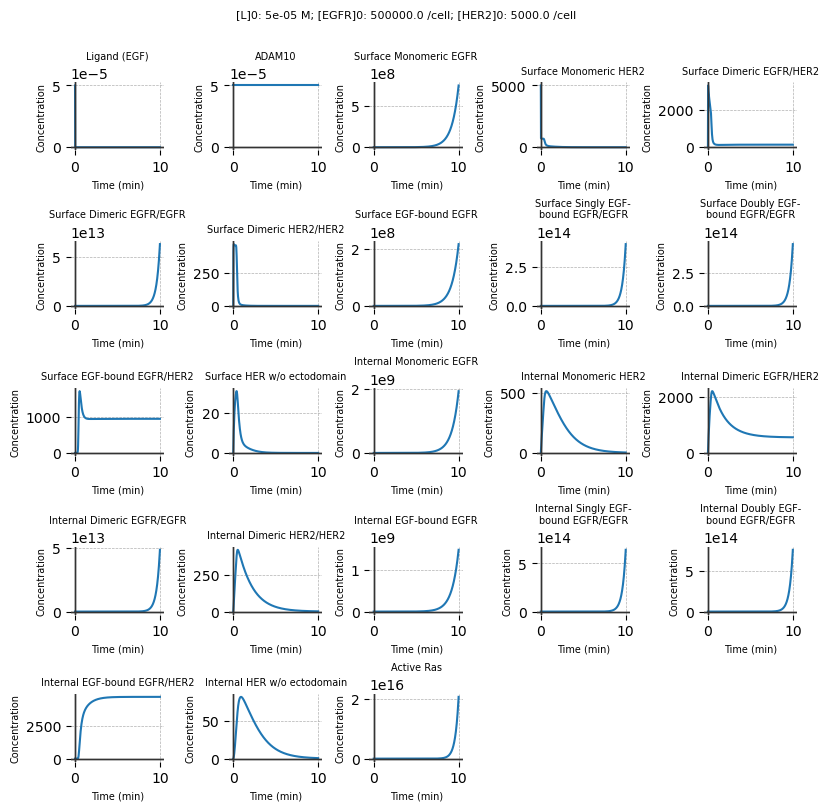

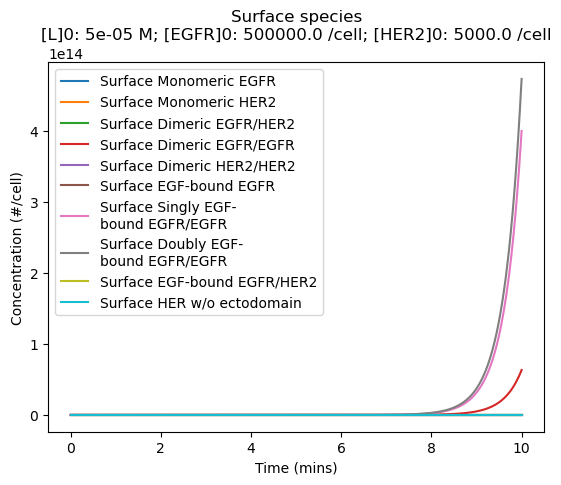

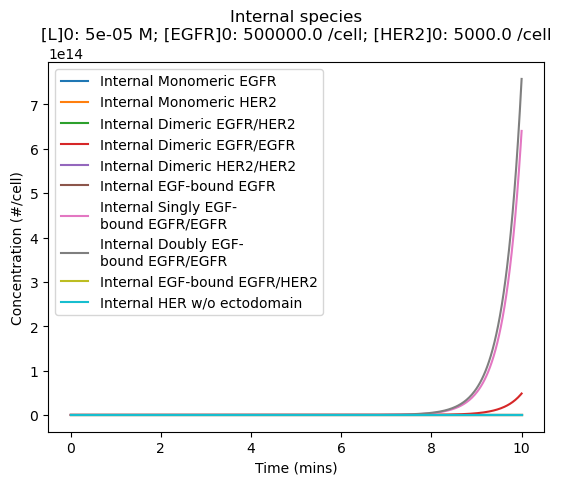

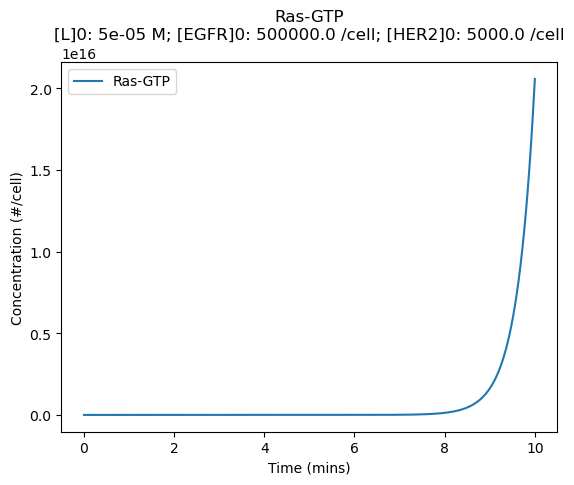

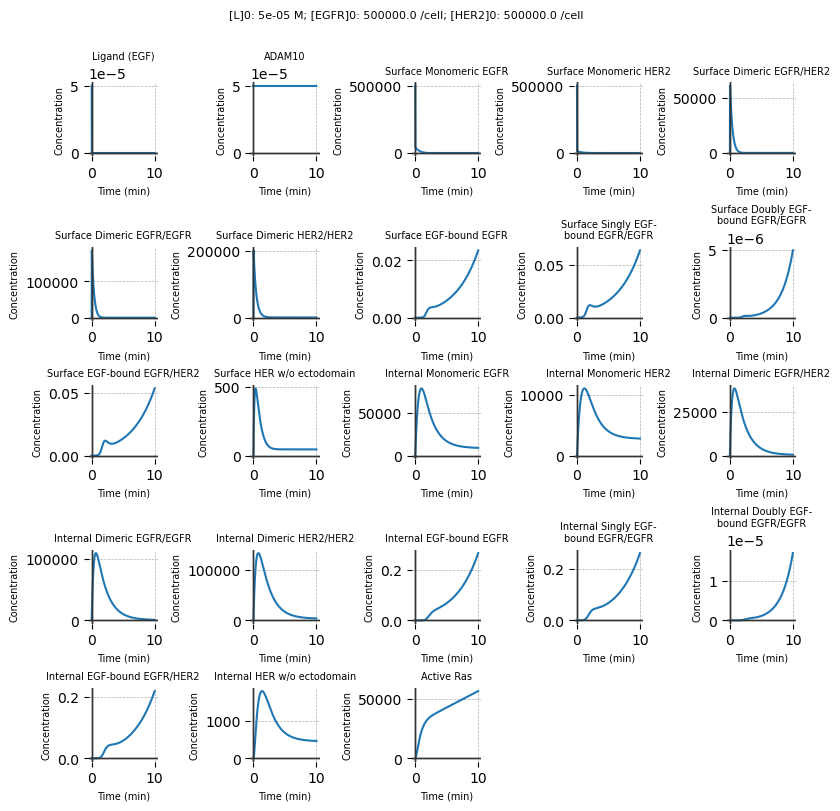

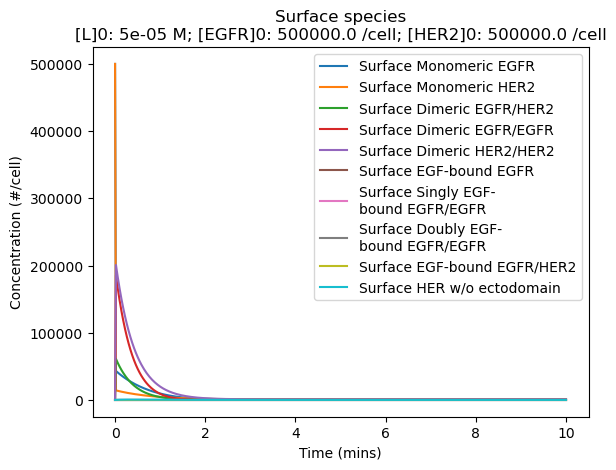

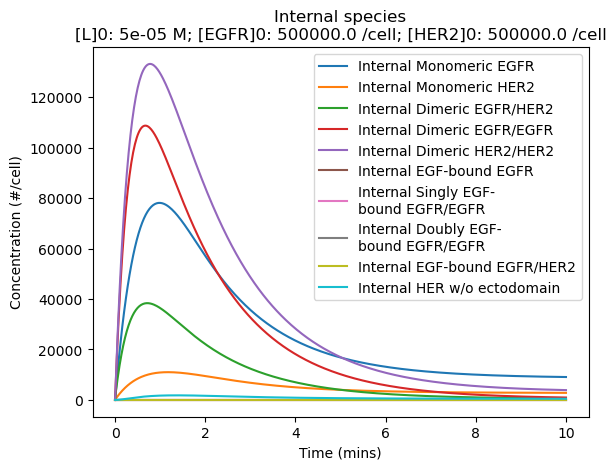

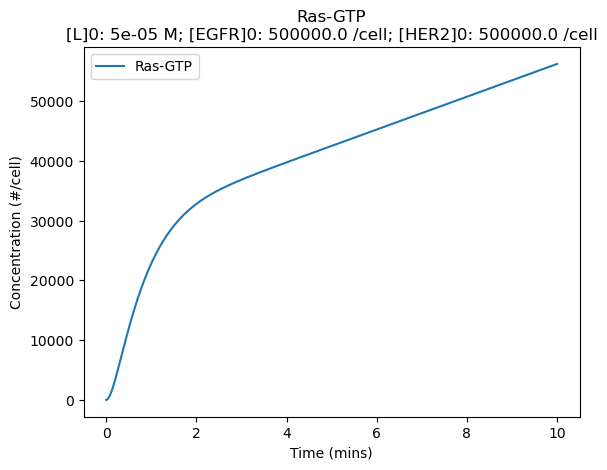

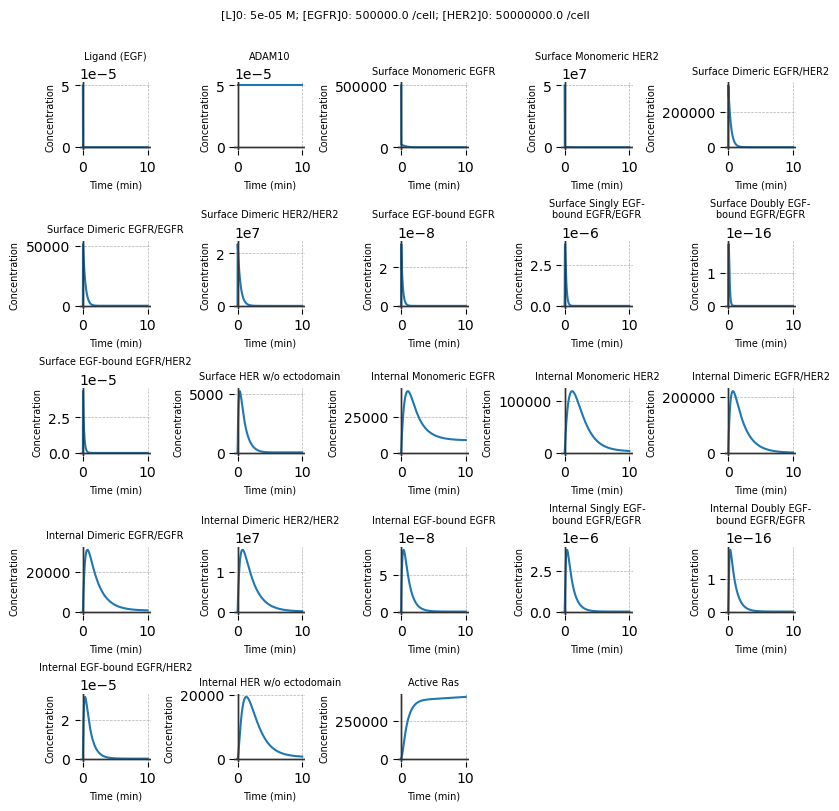

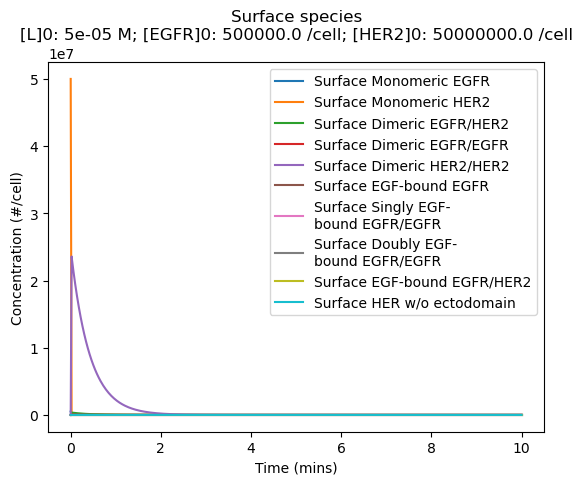

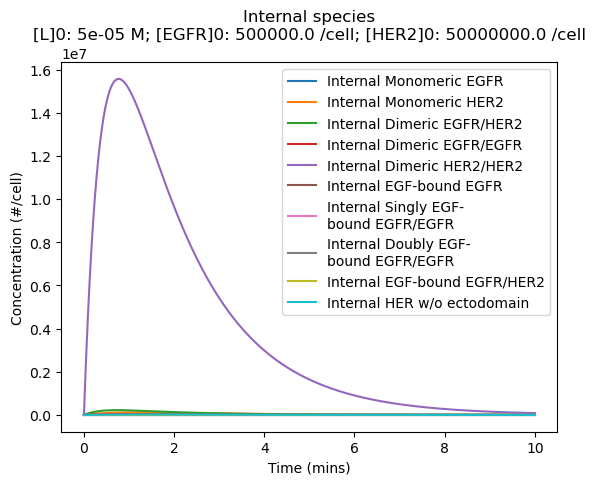

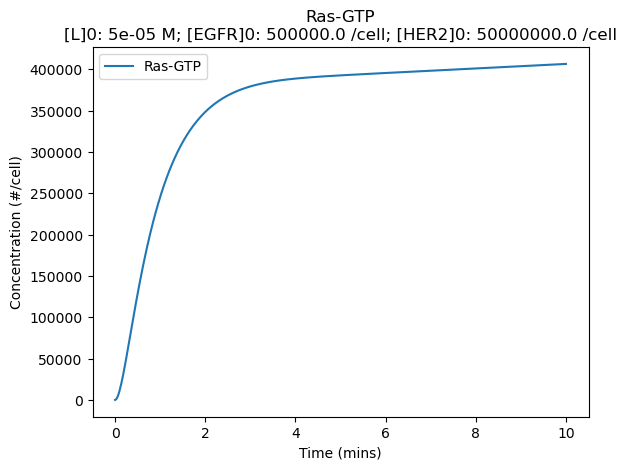

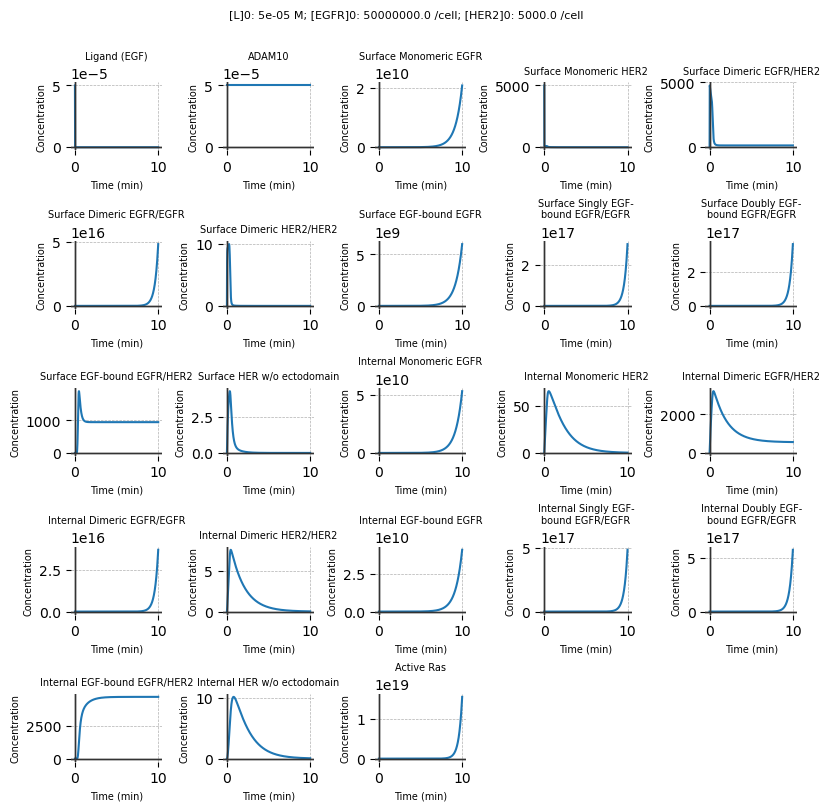

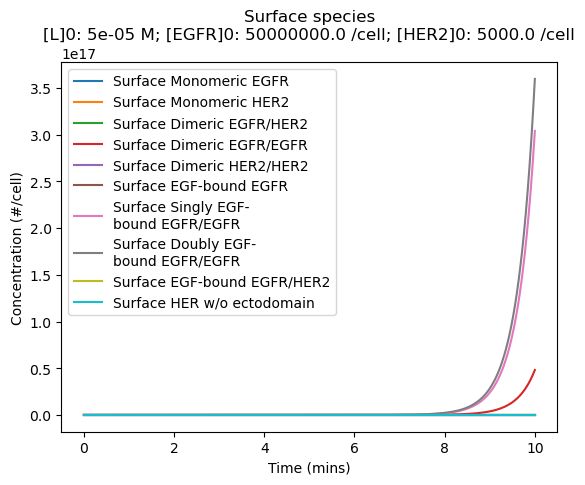

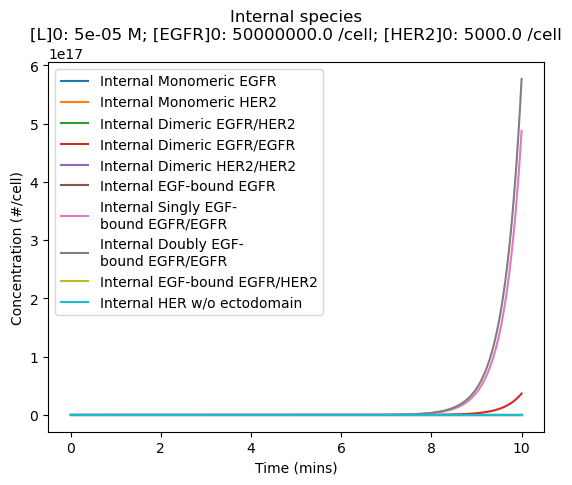

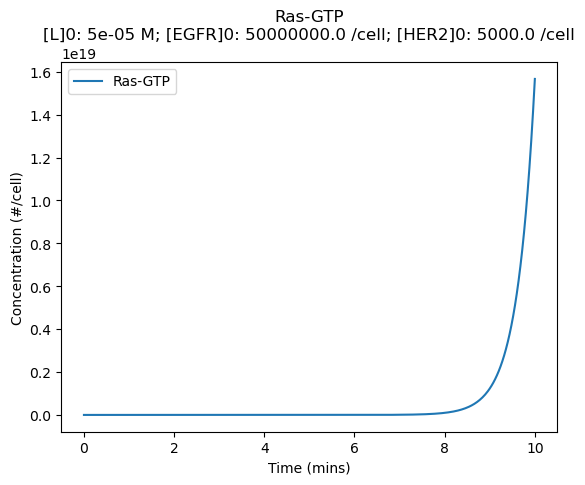

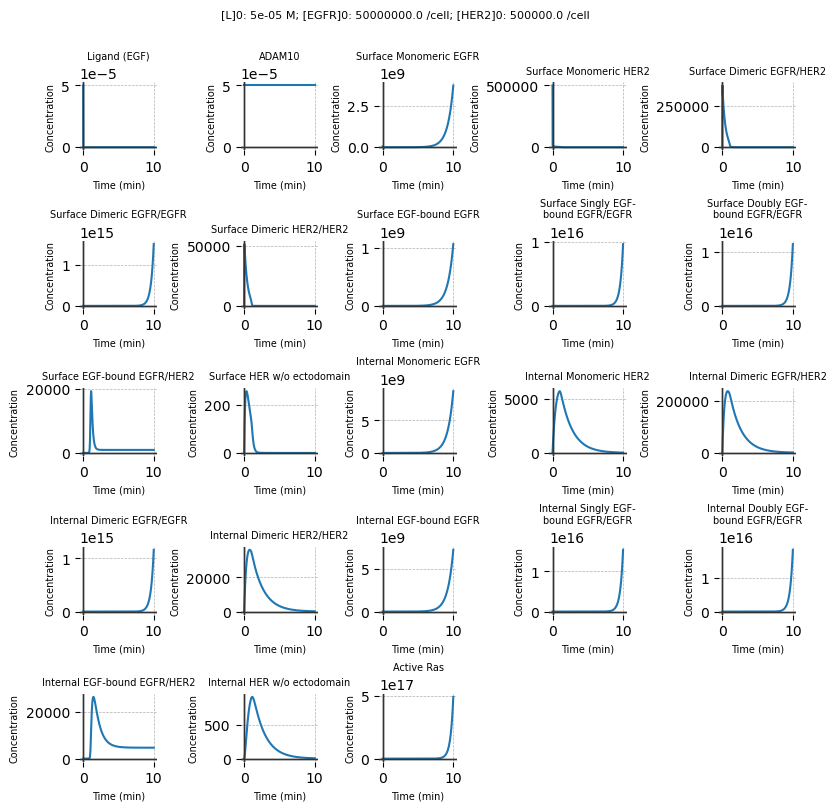

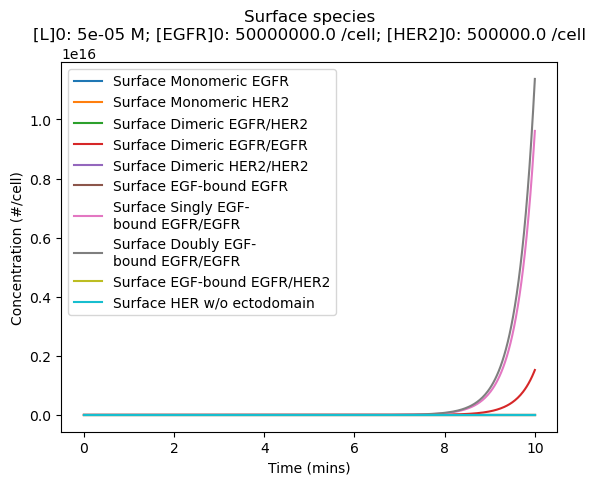

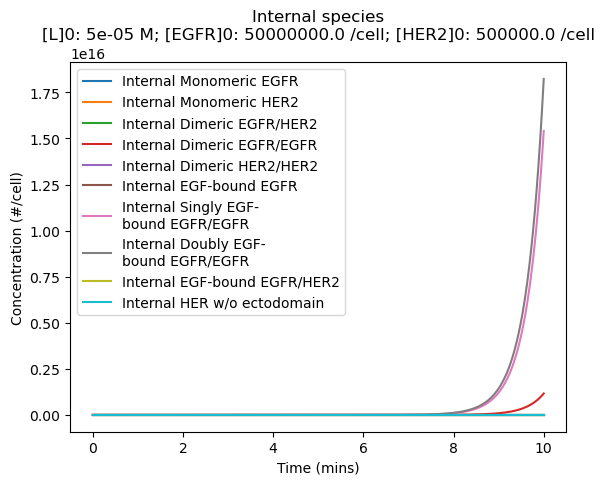

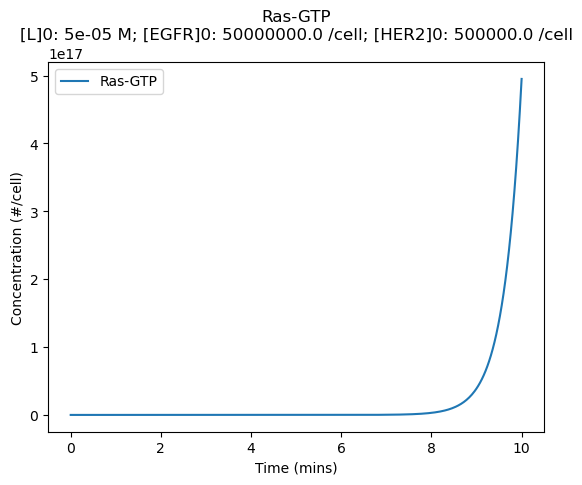

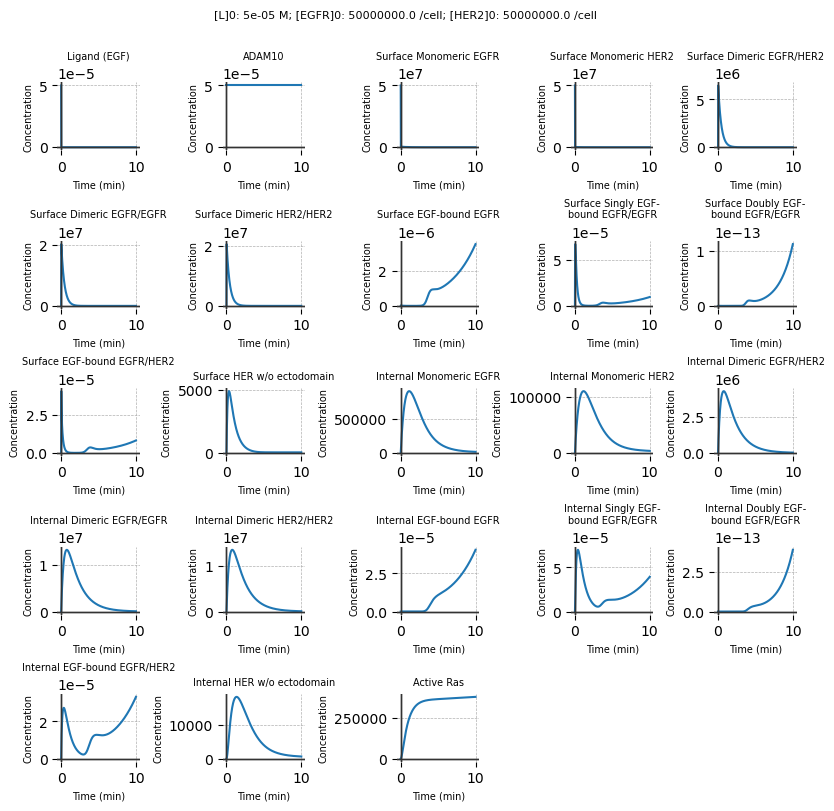

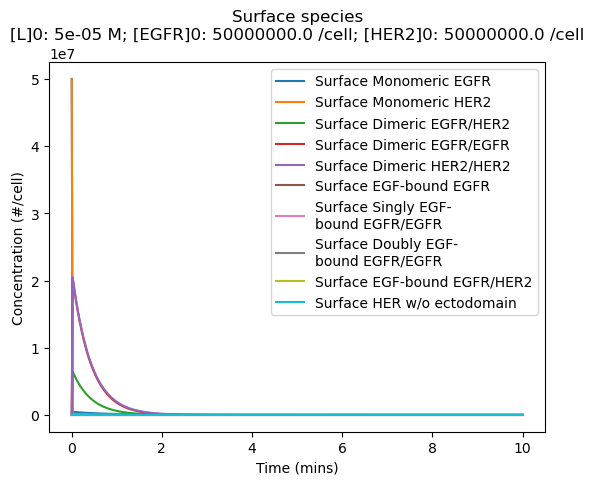

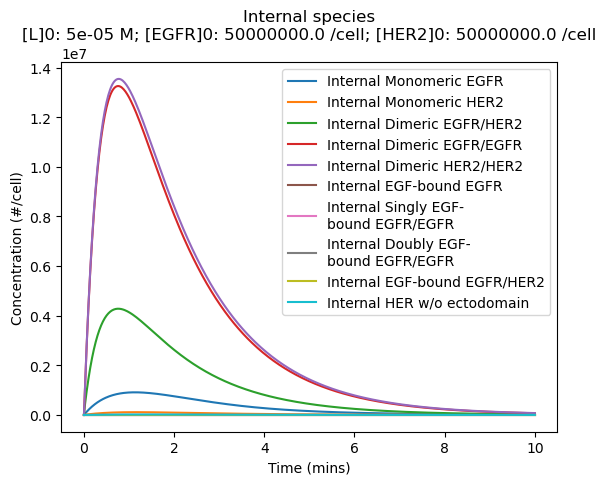

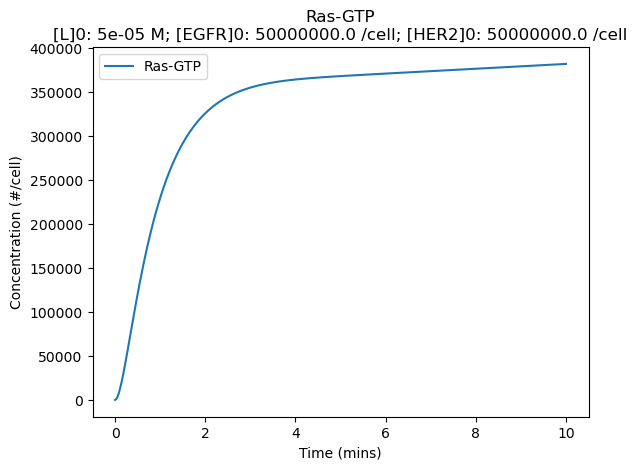

In [143]:
SAVE_FIGS = False   # CHANGE TO FALSE IF YOU WANT TO DISPLAY PLOTS AND NOT DOWNLOAD THEM

# create time axis
simulation_time_mins = 10  # minutes
t = np.linspace(0, simulation_time_mins*60, 500)

for ligand in ligands:
    for r1s in r1ss:
        for r2s in r2ss:
            constants = rate_constants()
            metadata = state_variable_metadata(ligand=ligand, r1s=r1s, r2s=r2s)

            # Run the simulation
            simulation_results, solution = simulate_binding_recycling_and_degradation(t, constants, metadata)
            fig, axes = plt.subplots(5, 5, figsize=(8, 8), layout="constrained")
            axes = axes.flatten()
            fig.suptitle(f'[L]0: {ligand} M; [EGFR]0: {r1s} /cell; [HER2]0: {r2s} /cell\n\n',
                         fontsize=8)


            plot_time_axis = simulation_results['t']/60

            for ax, (key, state_variable) in zip(axes,metadata.items()):
                ax.plot(plot_time_axis, simulation_results[key])

                set_axes_labels(ax, 'Time (min)', 'Concentration', state_variable.description, fontsize=7)
                make_plot_look_good(ax)

            axes[-1].set_visible(False)
            axes[-2].set_visible(False)
            if SAVE_FIGS:
                plt.savefig(f'all_ligand_{ligand}_r1s_{r1s}_r2s_{r2s}.png', dpi=300)
                plt.close(fig)
            else:
                plt.show()

            # make some overlay plots 
            for key, state_variable in metadata.items():
                if 's' in key and 'Ras' not in key and 'shedi' not in key:   # surface species
                    plt.plot(plot_time_axis, simulation_results[key], label=metadata[key].description)

            plt.xlabel('Time (mins)')
            plt.ylabel('Concentration (#/cell)')
            plt.legend()
            plt.title(f'Surface species\n[L]0: {ligand} M; [EGFR]0: {r1s} /cell; [HER2]0: {r2s} /cell')
            if SAVE_FIGS:
                plt.savefig(f'surface_ligand_{ligand}_r1s_{r1s}_r2s_{r2s}.png', dpi=300)
                plt.close()
            else:
                plt.show()

            for key, state_variable in metadata.items():
                if 'i' in key:   # internal species
                    plt.plot(plot_time_axis, simulation_results[key], label=metadata[key].description)

            plt.xlabel('Time (mins)')
            plt.ylabel('Concentration (#/cell)')
            plt.legend()
            plt.title(f'Internal species\n[L]0: {ligand} M; [EGFR]0: {r1s} /cell; [HER2]0: {r2s} /cell')
            if SAVE_FIGS:
                plt.savefig(f'internal_ligand_{ligand}_r1s_{r1s}_r2s_{r2s}.png', dpi=300)
                plt.close()
            else:
                plt.show()

            # plot Ras-GTP only
            plt.plot(plot_time_axis, simulation_results['Ras-GTP'], label='Ras-GTP')
            plt.xlabel('Time (mins)')
            plt.ylabel('Concentration (#/cell)')
            plt.legend()
            plt.title(f'Ras-GTP\n[L]0: {ligand} M; [EGFR]0: {r1s} /cell; [HER2]0: {r2s} /cell')
            if SAVE_FIGS:
                plt.savefig(f'Ras_ligand_{ligand}_r1s_{r1s}_r2s_{r2s}.png', dpi=300)
                plt.close()
            else:
                plt.show()

## 2) Sweep over different rate constants, with fixed ligand and receptor concentrations

In [142]:
SAVE_FIGS = True   # CHANGE TO FALSE IF YOU WANT TO DISPLAY PLOTS AND NOT DOWNLOAD THEM
for ligand in [0, 50e-6]:   # maintain 0 ligand control
    for k_c in k_cs:
        for k_on in k_ons:
            for k_off in k_offs:
                constants = rate_constants(k_c=k_c, k_on=k_on, k_off=k_off)
                metadata = state_variable_metadata(ligand=ligand, r1s=50e4, r2s=50e4)

                # Run the simulation
                simulation_results, solution = simulate_binding_recycling_and_degradation(t, constants, metadata)
                fig, axes = plt.subplots(5, 5, figsize=(8, 8), layout="constrained")
                axes = axes.flatten()
                fig.suptitle(f'k_c: {k_c} #/cell /min; k_on: {k_on} /M /min; k_off: {k_off} /min; \n[L]0={ligand}\n\n',
                            fontsize=8)

                plot_time_axis = simulation_results['t']/60

                for ax, (key, state_variable) in zip(axes,metadata.items()):
                    ax.plot(plot_time_axis, simulation_results[key])

                    set_axes_labels(ax, 'Time (minutes)', 'Concentration', state_variable.description, fontsize=7)
                    make_plot_look_good(ax)
                    
                axes[-1].set_visible(False)
                axes[-2].set_visible(False)
                if SAVE_FIGS:
                    plt.savefig(f'all_kc_{k_c}_kon_{k_on}_koff_{k_off}_L0_{ligand}.png', dpi=300)
                    plt.close()
                else:
                    plt.show()


                # make some overlay plots 
                for key, state_variable in metadata.items():
                    if 's' in key and 'Ras' not in key and 'shedi' not in key:   # surface species
                        plt.plot(plot_time_axis, simulation_results[key], label=metadata[key].description)

                plt.xlabel('Time (mins)')
                plt.ylabel('Concentration (#/cell)')
                plt.legend()
                plt.title(f'Surface species\nk_c: {k_c} #/cell /min; k_on: {k_on} /M /min; k_off: {k_off} /min; \n[L]0={ligand}')
                if SAVE_FIGS:
                    plt.savefig(f'surface_kc_{k_c}_kon_{k_on}_koff_{k_off}_L0_{ligand}.png', dpi=300)
                    plt.close()
                else:
                    plt.show()

                for key, state_variable in metadata.items():
                    if 'i' in key:   # internal species
                        plt.plot(plot_time_axis, simulation_results[key], label=metadata[key].description)

                plt.xlabel('Time (mins)')
                plt.ylabel('Concentration (#/cell)')
                plt.legend()
                plt.title(f'Internal species\nk_c: {k_c} #/cell /min; k_on: {k_on} /M /min; k_off: {k_off} /min; \n[L]0={ligand}')
                if SAVE_FIGS:
                    plt.savefig(f'internal_kc_{k_c}_kon_{k_on}_koff_{k_off}_L0_{ligand}.png', dpi=300)
                    plt.close()
                else:
                    plt.show()

                # plot Ras-GTP only
                plt.plot(plot_time_axis, simulation_results['Ras-GTP'], label='Ras-GTP')
                plt.xlabel('Time (mins)')
                plt.ylabel('Concentration (#/cell)')
                plt.legend()
                plt.title(f'Ras-GTP\nk_c: {k_c} #/cell /min; k_on: {k_on} /M /min; k_off: {k_off} /min; \n[L]0={ligand}')
                if SAVE_FIGS:
                    plt.savefig(f'Ras_kc_{k_c}_kon_{k_on}_koff_{k_off}_L0_{ligand}.png', dpi=300)
                    plt.close()
                else:
                    plt.show()

/Users/katie/opt/anaconda3/envs/py312/lib/python3.12/site-packages/scipy/integrate/_ivp/common.py:346: RuntimeWarning: overflow encountered in multiply
  h_new = (y[ind] + new_factor * y_scale[ind]) - y[ind]
/Users/katie/opt/anaconda3/envs/py312/lib/python3.12/site-packages/scipy/integrate/_ivp/common.py:315: RuntimeWarning: overflow encountered in multiply
  h = (y + factor * y_scale) - y
/Users/katie/opt/anaconda3/envs/py312/lib/python3.12/site-packages/scipy/integrate/_ivp/common.py:345: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/Users/katie/opt/anaconda3/envs/py312/lib/python3.12/site-packages/scipy/integrate/_ivp/common.py:367: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


## 3) Characterize impact of shedding (fixing all other parameters)

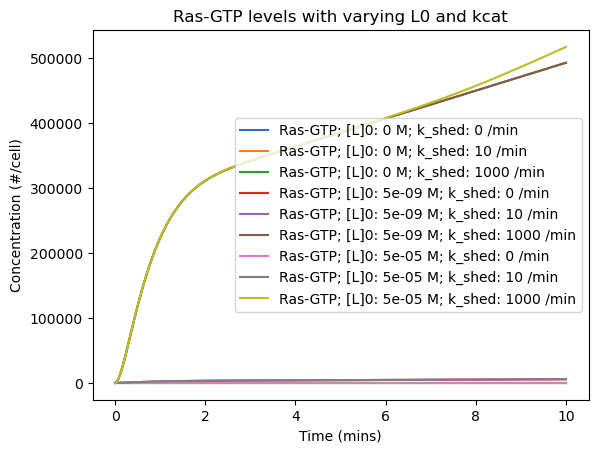

In [161]:
k_sheds=[0, 10, 1000]  # 0 reflects NO SHEDDING; other kcats are inspired by general protease activity from literature

SAVE_FIGS = True   # CHANGE TO FALSE IF YOU WANT TO DISPLAY PLOTS AND NOT DOWNLOAD THEM

# create time axis
simulation_time_mins = 10  # minutes
t = np.linspace(0, simulation_time_mins*60, 500)

for ligand in ligands:
    for k_shed in k_sheds:
        constants = rate_constants(k_shed=k_shed)
        metadata = state_variable_metadata(ligand=ligand, r1s=50e4, r2s=50e4)

        # Run the simulation
        simulation_results, solution = simulate_binding_recycling_and_degradation(t, constants, metadata)


        # plot Ras-GTP only
        plt.plot(plot_time_axis, simulation_results['Ras-GTP'], label=f'Ras-GTP; [L]0: {ligand} M; k_shed: {k_shed} /min')
        plt.xlabel('Time (mins)')
        plt.ylabel('Concentration (#/cell)')
        plt.legend()
        plt.title(f'Ras-GTP levels with varying L0 and kcat')

            
if SAVE_FIGS:
    plt.savefig(f'Ras_ligand_shedding.png', dpi=300)
else:
      plt.show()